### Schedule

1. [~30 min] Intro presentation
2. [~60 min] Chapter 1 & 2 (Random & Mutate Loop)
3. [~15 min] Break
4. [~10 min] Discussion on warmup & compound difference
5. [~60 min] Chapter 3 (ML, ML Loop)
6. [~30 min] Chapter 4: Sending your best solution
7. [~15 min] Quick presentation by best performing solution

# Chapter 1: Random Screening In Known Compounds

### 📝 Meet our team

You were selected to be a lead medicinal chemist in a critical drug discovery project for our company. Your goal is to find a novel GSK3β inhibitor, which could be used to treat cancer. Your first idea is to buy a lot of diverse molecules found in the ZINC database and verify their biological activity in the lab. ZINC is one of the databases in which you can find small molecules that are available for purchase. Some other databases offer even more molecules that can be synthesized on demand. Let's select a random batch of molecules for testing to get started!

<img src="https://github.com/molecule-one/mlinpl-23-workshops/blob/main/assets/lab1.png?raw=true" width="400px" />

### 📘 Glossary

*Dopamine Receptor D$_2$ (DRD2)* - a G protein-coupled receptor that binds dopamine; a common target for antipsychotic drugs.

*Glycogen synthase kinase-3 beta (GSK3β)* - an enzyme that can be targeted to treat cancer.

*High-throughput screening (HTS)* - an experiment in which biological activity is tested automatically for many compounds in parallel.

*Inhibitor* - a molecule that blocks (inhibits) its biological target (usually a protein).

*Library* - a collection of molecules

*Medicinal chemistry* - a branch of chemistry that investigates the interactions between small molecules (or other compounds with potential therapeutic effects) and their biological targets, e.g. to learn how drugs work in the organism; this knowledge is often used to propose new molecules as drug candidates.

*Virtual screening (VS)* - an application of computational tools for finding active compounds in big virtual libraries of compounds.

*ZINC* - a database of readily purchasable compounds that can be used for virtual screening.

### ⚒️ Setup & Imports

Set the environment:
```
conda env create --file env.yml
```
And use de-novo-workshop for this notebook

In [ ]:
!conda env create --file env.yml

In [1]:
!pip install PyTDC rdkit dataclasses_json mols2grid selfies more_itertools rich

In [1]:
from rdkit import Chem
import rdkit

In [2]:
import os
your_path = "C:/Users/annab/Desktop"
os.chdir(f"{your_path}/Automating_Science/molecules")
os.makedirs(your_path, exist_ok=True)

### ⚒️ Global Variables

In [3]:
SERVER_URL = "http://127.0.0.1:5000"
# YOUR_TOKEN = "0d9fc9ac-49d8-4763-93f2-deaea566d78c" ### TODO: Paste your token here
YOUR_TOKEN = "9f92b3b4-1864-4ea0-90d3-37c808acb2ab"

### ⚒️ Exercise 1 Warmup: Requesting your first HTS experiment and achieve 28% score on GSK3B

Your task is to find early leads for GSK: achieving at least 28%. It will likely require tuning the budget of your experiments.

In [4]:
import sys
import re

project_dir = 'C:\\Users\\annab\\Desktop\\Automating_Science'
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)

In [5]:
# 1. Sample random compounds from the ZINC dataset

from molecules.src.compound_spaces import SmallZINC
from molecules.src.organic import show_molecules

budget = 1000
library = SmallZINC()
candidates = library.sample(budget)
candidates_smiles = [rdkit.Chem.MolToSmiles(mol) for mol in candidates]
show_molecules(candidates)

Found local copy...
Loading...
Done!


MolGridWidget()

In [6]:
# 2. Request running HTS on the selected compounds
from src.al_loop import Loop, LeadCompound
from src.server_wrapper import FlaskAppClient

loop = Loop(base_dir=".", user_token=YOUR_TOKEN, target="GSK3β_server")
client = FlaskAppClient(base_url=SERVER_URL)

tested_molecules = loop.test_in_lab_and_save([LeadCompound(smiles=s) for s in set(candidates_smiles)], client=client)
show_molecules(tested_molecules)

[13:35:22] Saving results to ..                                                                       ]8;id=257115;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=529954;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#44\44]8;;\

[13:36:11] Saving results to 2.json.                                                                 ]8;id=405727;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=728575;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

MolGridWidget()

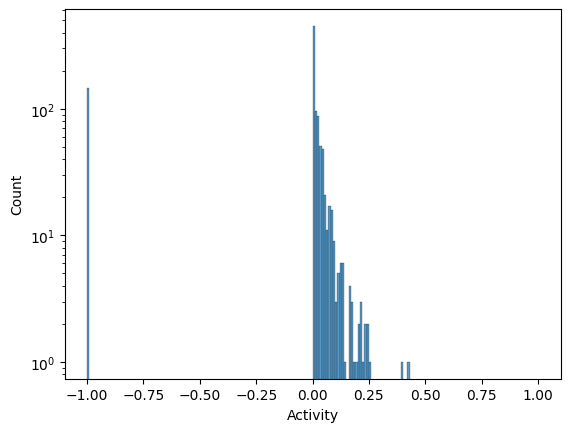

In [7]:
# 3. Show the summary of the screening results

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

data = pd.DataFrame({'Activity': [mol.activity for mol in tested_molecules]})
sns.histplot(data, binrange=(-1, 1), binwidth=0.01, x='Activity', log=True) # -1 corresponds to nonsynthesizable compounds
plt.show()

In [ ]:
# 4. Go to the leaderboard at https://orca-careful-remarkably.ngrok-free.app/leaderboard can you see your result?

In [29]:
# 5. Code up random loop and run it!

from pathlib import Path
import shutil
from typing import List
from rich.console import Console
import numpy as np
import itertools
console = Console()

class RandomLoop(Loop):
    """Samples random compounds from the ZINC database."""
    def __init__(self, base_dir: Path, user_token=None, target="GSK3β_server"):
        self.space = SmallZINC()
        super().__init__(base_dir, user_token, target)
        
    def propose_candidates(self, n_candidates: int) -> List[LeadCompound]:
        candidates = self.space.sample(n_candidates)
        smi = set([rdkit.Chem.MolToSmiles(mol) for mol in candidates])

        return [
            LeadCompound(s, None, None) for s in smi
        ]

In [30]:
# Let's define a running function
def run(loop, budget=1000, purge=False, steps=10):
    target = loop.target
    user_token = loop.user_token

    if purge:
        shutil.rmtree(loop.base_dir, ignore_errors=True)

    os.makedirs(loop.base_dir, exist_ok=True)

    if target == "GSK3β":
        client = None
    else:
        client = FlaskAppClient(SERVER_URL)

    if loop.n_iterations > 0:
        raise ValueError(f"Already run. Please remove the folder {loop.base_dir} to run again.")

    metrics = []
    all_result: List[LeadCompound] = []
    budget_per_step = budget // steps
    assert budget % steps == 0 # for simplicity
    for step in range(steps):
        console.print(f"[red]Step {step}[/red]")
        candidates = loop.propose_candidates(budget_per_step)
        loop.test_in_lab_and_save(candidates, client=client)
        result: List[LeadCompound] = loop.load(iteration_id=step)
        all_result += result
        loop.generate_visualization(iteration_id=step)
        all_result_sorted = sorted(all_result, key=lambda x: x.activity, reverse=True)
        metrics.append({"top10": np.mean([x.activity for x in all_result_sorted[:10]]),
                        "top10_synth": np.mean([x.synth_score for x in all_result_sorted[:10]])})

    return metrics

In [31]:
loop = RandomLoop(base_dir="random", user_token=YOUR_TOKEN, target="GSK3β_server")
metrics = run(loop, purge=True, budget=1000, steps=10)

Found local copy...
Loading...
Done!


[13:42:47] Saving results to random.                                                                  ]8;id=889853;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=282994;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#44\44]8;;\

Step 0

[13:42:53] Saving results to random\0.json.                                                          ]8;id=124065;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=130813;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to random\visualize_0.html for 100 compounds from iteration 0.        ]8;id=658238;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=223156;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['O=C1NC2(CCCC2)C(=O)N1Cc1noc(-c2ccc(Cl)cc2)n1', 'CCCOc1ncnc(Nc2cc(Cl)cc(Cl)c2)c1N', 'C[C@@H]1OCC[C@@H]1c1nnc(-c2cccc(C(=O)[O-])c2)o1', 'O[C@H]1CCC[NH+](CCCOCCc2ccccc2)C1', 'C[C@H](CC(=O)N(C[C@@H]1CCCO1)C1CC[NH+](C)CC1)n1nnc2ccccc21', 'Cc1ccc(C(=O)N(C)[C@@H](C)c2cccnc2)c(C)n1', 'CC(C)CN(C)C(=O)[C@@H]1C[C@@H]1c1ccccc1C(F)(F)F', 'CCCCn1nnnc1CN1CCN(c2ccc3nncn3n2)CC1', 'CCn1c(C)cc(C(=O)CSc2nc(C)cs2)c1C', 'CC[NH+](Cc1ccsc1)[C@H](C)c1cccc(O)c1', 'C[C@@H](NC(=O)Nc1ccccc1CN1CCc2ccccc21)[C@@H]1CCCO1', 'O=C(Cc1ccc(CNC(=O)c2cnc3c(c2)NC(=O)CO3)cc1)Nc1ccccc1F', 'Cn1nc(C(=O)Nc2ccc(S(=O)(=O)[N-]c3ncccn3)cc2)ccc1=O', 'COCCCn1cnnc1[S@](=O)Cc1nc2ccccc2s1', 'COc1cc(/C=N/N=C2/NC(=O)[C@@H](CC(=O)c3ccc(C)c(C)c3)S2)ccc1O', 'CC1(C)CCC(C#N)([C@@H](O)c2cn3ccccc3n2)CC1', 'O=C(c1cn(C2CCN(S(=O)(=O)c3c(F)cccc3F)CC2)nn1)N1CCCCC1', 'CCn1cnnc1CNC(=O)c1cccc(F)c1Cl', 'CCOC(=O)[C@]1(C)[NH2+][C@@H](c2ccc(C(C)C)cc2)[C@H]2C(=O)N(CC)C(=O)[C@@H]21', 'O=C(NNC(=O)[C@@H]1[C@@H]2CC[C@@H](C2)[C@@H]1C(=O)[O-])c1cccc(Cl)c1', 'C[NH+]

MolGridWidget()

Step 1

[13:42:58] Saving results to random\1.json.                                                          ]8;id=50820;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=627712;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to random\visualize_1.html for 100 compounds from iteration 1.        ]8;id=778891;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=730215;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['CN(C)C(=O)c1cccc(N2CCC3(CC2)[C@H](C(=O)[O-])CC(=O)N3C)n1', 'O=C(Nc1cccc(-c2nnco2)c1)N(C[C@@H]1CCOC1)C1CC1', 'CC(C)[C@@H]([NH3+])[C@H](C)c1ccc(F)cc1', 'Cc1cc(C)c(NC(=O)CSc2nnc(-c3cccs3)n2C[C@H]2CCCO2)c(Cl)c1', 'Cc1ccc(C(F)(F)F)cc1N1C[C@H](O)CC1=O', 'COc1ccc(C(=O)[O-])cc1-c1cc(C)c(F)cc1F', 'CCCCCNC(=O)N(C)CCc1ccccn1', 'Cc1ccc(NC(=O)[C@@H](c2ccccc2)N2CCC(C(=O)N[C@H](C)C(C)C)CC2)cc1', 'COc1cc(C[NH2+]C[C@@H](C)C[C@@H](C)O)cc(Br)c1O', 'CCc1cc(C[NH+]2CCC(CC(=O)[O-])CC2)n(C)n1', 'Cc1noc(C)c1[C@@H](C)CN[C@H](C)c1ccc(C(C)C)cc1', 'CNC(=O)c1cc2cc(F)ccc2[nH]1', 'CC[C@H](C)N(Cc1ccncc1)C(=O)c1cc(S(N)(=O)=O)ccc1C', 'COC(=O)[C@H](C)NC(=O)c1ccc(Nc2ccccc2)c([N+](=O)[O-])c1', 'COc1ccc(N2CCN(C(=O)[C@H]3N=NC4=C3CSc3ccccc34)CC2)cc1', 'CN(C)S(=O)(=O)N1C[C@@H]2CC[C@H](C1)N(C(=O)c1ccc(Cl)cc1)C2', 'CCCC(=O)Nc1cccc(NC(=O)N[C@@H](C)c2c(C)noc2C)c1', 'COc1cc(NCc2cccn2-c2nnc(N3CCC(C)CC3)s2)cc(OC)c1', 'C[NH2+][C@H](c1ccc(OC)c(OC)c1)[C@H]1CCO[C@H]1C', 'CCc1ccc(C(=O)[C@H](C)Sc2nnc([C@H]3CCS(=O)(=O)C3)n2C)cc1', 'O=C(NC

MolGridWidget()

Step 2

[13:43:03] Saving results to random\2.json.                                                          ]8;id=970930;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=192407;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to random\visualize_2.html for 100 compounds from iteration 2.        ]8;id=172988;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=539075;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['COc1ccc(S(=O)(=O)NC[C@](C)(O)C2CC2)cc1F', 'C[C@H]([NH2+][C@H]1CCCC[C@@H]1OCc1ccccc1)C1CCOCC1', 'CCOC(=O)c1c(NC(=O)c2nnn(-c3ccc(C)cc3)c2C)sc2c1CC[C@@H](C)C2', 'COc1ccc(OCc2nnc(S[C@@H](C)C#N)n2-c2ccccc2)cc1', 'COc1ccc(F)cc1NC(=O)[C@H]1CC(=O)N(c2ccccc2OC)C1', 'CO[C@H]1[C@@H]2CCC[C@@H]2C(=O)C[C@@H]2CC[C@@]3(C2)O[C@H]13', 'C1=C(CN2CCN(c3cccs3)CC2)COc2ccccc21', 'CCC(CC)N(CCOC)c1cccc(F)c1C#N', 'CCCCSCC(=O)N1CCC[C@H](O)C1', 'CN1C(=O)C[C@H](C(=O)NCc2ccnc(OC(C)(C)C)c2)[C@@H]1c1cccnc1', 'CCC[C@H](Cc1ccccc1)NC(=O)N1CCC([NH+]2CCCC2)CC1', 'C[C@@H]1CN(C(=O)NC[C@](C)(O)CC(=O)[O-])C[C@@H]1C', 'CS[C@@H](C)C(=O)Nc1ccc(-n2ccnc2)nc1', 'CCC[C@H]1NC(=O)CCN([C@@H](C)c2c(C)noc2C)C1=O', 'CC(=O)N1CCc2[nH]cnc2C12CCN(C(=O)c1ccc(C)c(C)c1)CC2', 'C[C@@H]1CC[NH+](CCC(=O)Nc2ccccc2C(=O)NC2CC2)C[C@@H]1O', 'CSCC[C@H](C)N(C)C(=O)c1cnc([C@H]2CCCO2)s1', 'O=C(COCc1ccccc1Cl)N[C@@H]1CCSc2ccc(F)cc21', 'COc1cc(NC(=O)C(C)(C)CC(C)C)c(OC)cc1Cl', 'CC1=C[C@@H]([C@@H]2NN[C@H](S)N2/N=C/C(C)=C/c2ccccc2)N=N1', 'CNC(=O)c1ccsc1NC(=O)Cc1cc

MolGridWidget()

Step 3

[13:43:09] Saving results to random\3.json.                                                          ]8;id=354449;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=182528;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to random\visualize_3.html for 100 compounds from iteration 3.        ]8;id=167768;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=998730;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['CC(C)NS(=O)(=O)c1ccsc1CO', 'CC(=O)c1cccc(Oc2ncnc3sccc23)c1', 'CC[C@H](C)Nc1ccc(N)c(OC(C)C)n1', 'COc1ccc(NC(=O)Cn2ncn3nc(-c4ccc(C)cc4)cc3c2=O)c(OC)c1', 'COC(=O)[C@H]1CCCCC[C@H]1NC(=O)Cc1ccccc1C', 'C[S@](=O)CCNS(=O)(=O)c1ccc2c(c1)NC(=O)C(C)(C)O2', 'Cc1ccc2nc(N3CCC(C(=O)NCCc4cccc(F)c4)CC3)nc(C)c2c1', 'CCc1nn(C)c(OC)c1CNS(=O)(=O)N(C)CC', 'CCC[NH2+][C@@H](c1cscc1Br)c1c(F)cccc1F', 'CS[C@H]1CCC[C@H]1NC(=O)N(C)Cc1ccc([S@](C)=O)cc1', 'O=C(Nc1cccc(-c2cn3ccsc3n2)c1)c1ccccc1I', 'CCC[C@H](C)NC(=S)Nc1ccc(C)c(Cl)c1', 'CC[S@](=O)[C@@H](C)C(=O)N1CCCc2ccccc21', 'O=[N+]([O-])c1cc(C(F)(F)F)ccc1Oc1cccnc1', 'COC(=O)NCC(=O)Nc1nc(-c2ccc(F)cc2)c(C)s1', 'N#C/C(=C/c1cccc(OC2CCCC2)c1)C(=O)[O-]', 'C[C@@H]1C/C(=N\\NC(=O)C(N)=O)CC(C)(C)C1', 'CN(Cc1cccc(C#N)c1)C(=O)Nc1ccc(C#N)cc1', 'O=C(NC1CCCC1)[C@H]1CCCN(c2nnc(N3CCCCC3=O)s2)C1', 'COc1cccc([C@H]2C[NH+]=C(N)N2CC(C)C)c1OC', 'CCOCc1ccccc1CNC(=O)c1cc2cc(Cl)ccc2nc1C', 'Cc1cc(C[C@H](C)N[C@H]2CCOc3ccc(F)cc32)n[nH]1', 'CCC[NH2+]C1CCC([NH+](C)Cc2nnc(C)n2C)CC1', 'C/C(=C/CCC

MolGridWidget()

Step 4

[13:43:14] Saving results to random\4.json.                                                          ]8;id=195402;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=620079;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to random\visualize_4.html for 100 compounds from iteration 4.        ]8;id=706139;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=272711;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['Cc1ncncc1C(=O)NC1CC[NH+](Cc2cc(-c3ccc(F)cc3)nn2C)CC1', 'CC(C)(C)C(=O)N1CCN(c2ccc(C(=O)Nc3ccccc3)nn2)CC1', 'CC1(C)C(Nc2[nH+]ncc3ccccc23)C1(C)C', 'CN1C(=O)COc2ccc(NC(=O)[C@@H]3CCCC[C@H]3C(F)(F)F)cc21', 'Cc1ccsc1[C@H](C)[NH2+]C[C@H]1CC[C@H](C(N)=O)O1', 'C[C@@H]1CCN(C(=O)CC2(O)CCCCC2)[C@H]2CCCC[C@H]12', 'CCc1c(C(=O)Nc2ccc3c(c2)OCO3)cnn1Cc1ccccc1', 'O[C@@H](C[NH2+][C@@H]1CCCc2ccc(Br)cc21)C[NH+]1CCCC1', 'N#C/C(=C/c1ccc(O)c([N+](=O)[O-])c1)c1nc(-c2ccc(Br)cc2)cs1', 'CC[C@](C)(C(=O)[O-])n1nnnc1-c1ccco1', 'Cc1ccc(S(=O)(=O)N2CC[C@@H](C)[C@H](O)C2)cc1Br', 'C[C@H](C(N)=O)N1CCN(Cc2nc3ccccc3n2C(F)F)CC1', 'C[C@H](C(=O)NC1(C)Cc2ccccc2C1)c1ccsc1', 'CN(C)C(=O)[C@@H]1CC[C@H](CNC(=O)NCc2ccc(-n3cccn3)cc2)O1', 'CCCNC(=O)NC(C)(C)c1ncc(C)s1', 'CC(C)[NH+](Cc1ccc([N+](=O)[O-])cc1)CC1CC[NH2+]CC1', 'CC(C)C[C@H](NC(=O)c1ccc(Cl)cc1Cl)C(=O)N(C)[C@H]1CCS(=O)(=O)C1', 'CC(C)COc1ccc(N)cc1F', 'Cc1ccccc1NC(=O)[C@@H]1[C@H](C)Nc2ncnn2[C@@H]1c1ccc(O)cc1', 'CC[C@@H](C)OC(=O)[C@H](C)n1cnc2sc3c(c2c1=O)CC[C@H](C)C3', 'CCC1(CC)[

MolGridWidget()

Step 5

[13:43:20] Saving results to random\5.json.                                                          ]8;id=170583;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=344864;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to random\visualize_5.html for 100 compounds from iteration 5.        ]8;id=118990;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=893715;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['NC(=O)Nc1ccc(C(=O)N[C@@H]2C[C@H]3C[C@@H]2[C@H]2CCC[C@H]32)cc1', 'O=C(Cc1nc(-c2ccccc2)cs1)Nc1ccccc1', 'CCOc1ccc(CN2CCN(C(=O)c3cnn(C)c3)CC2)cc1', 'CCS(=O)(=O)CCn1ccc(NC(=O)c2ccccc2C)n1', 'C[C@@H]1Oc2ccc(NC(=O)[C@@H](C)Oc3ccc(Cl)c(Cl)c3)cc2NC1=O', 'CCc1ccc(/C(C)=N/NC(=O)[C@@H]2C[C@@H]2c2ccccc2)cc1', 'C[C@H]1C[C@@H]1C(=O)Nc1ccc(C(=O)Nc2ccc3c(c2)CCO3)cc1', 'Cc1ccc2[nH]c(=O)c3cc(C(=O)N(C)c4cccc(Cl)c4)sc3c2c1', 'CCOCC(=O)Nc1ccc(S(=O)(=O)/N=C(/C)[O-])cc1', 'CCCCNC(=O)c1cc2c(-c3cccc(OC)c3)nn(C)c2s1', 'S=C(Nc1ccccc1Cl)N1CCCC[C@H]1c1cccnc1', 'C[S@@](=O)Cc1cc(NC(=O)C2CC=CC2)ccc1Cl', 'COc1ccccc1[C@@H](C)NC(=O)CSc1nccn1-c1ccccc1C', 'CC(C)[NH+](Cc1cn(C)nc1-c1cccnc1)C1CCC1', 'COC(=O)[C@]1(NCC(C)C)CCCS[C@H]1C', 'CCC[NH+]1CCC(NC(=O)NC[C@H](c2cnn(C)c2)[NH+](C)C)CC1', 'Clc1cccc(C[NH2+]Cc2ccc3nccnc3c2)c1', 'Cc1ccc([C@H](C)NC(=O)Nc2ccc(Oc3cccnc3)nc2)cc1F', 'O=C(Nc1cccc(N2C(=O)c3ccccc3C2=O)c1)c1cccnc1', 'Cc1c(Cl)cccc1-n1c(S[C@@H](C)C(N)=O)nc2ccccc2c1=O', 'C[C@H]1CCCN(C(=O)CN2CCC([NH3+])CC2)CC1', 'Cc1ccc2c(

MolGridWidget()

Step 6

[13:43:25] Saving results to random\6.json.                                                          ]8;id=961535;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=843386;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to random\visualize_6.html for 100 compounds from iteration 6.        ]8;id=516716;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=929513;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['CN1CCO[C@H]([C@H](O)c2ccc(F)c(F)c2F)C1', 'CC(=O)c1cccc(OCC(=O)NCC(C)C)c1', 'CNC(=O)[C@H]1CN(c2ccc(OC)cc2)CCN1c1cc(C)ncn1', 'CC[C@@H]([NH2+][C@H](C)C1CCC1)c1cnn(C)c1', 'Cc1nnc(NC(=O)c2cc3c(s2)CCCCCC3)s1', 'c1ncn(-c2ccc(C[NH+]3CCC(OC4CCOCC4)CC3)cc2)n1', 'Cc1cn2c(CN(C)C(=O)c3cc(C(N)=O)c[nH]3)c(C)nc2s1', 'COc1ccc(NC(=O)C(=O)NCC[NH+]2CCCC[C@@H]2C)c(C)c1', 'Cc1cc([N+](=O)[O-])ccc1NC(=O)CN1C(=O)[C@@H]2[C@H](C1=O)[C@@H]1C=C[C@H]2C1', 'Oc1cccc(C[NH+]2CCC[C@H]2c2cccc3c2OCCO3)c1', 'Nc1nc(C[NH+]2CCCCCCC2)nc2ccccc12', 'COc1cccc(C(=O)Nc2ccc(NC(C)=O)cc2C(F)(F)F)n1', 'N#CCCN(CCC#N)S(=O)(=O)c1cccs1', 'O=S(=O)(Cc1ccccc1Cl)NCC1(O)CCOCC1', 'COc1ccc(C2=NN(CN3C(=O)C(=O)c4ccccc43)[C@@H](c3ccco3)C2)cc1', 'C[C@H]1Cc2ccccc2N1C(=O)[C@@H]1CCCN(C(=O)NC2CC2)C1', 'Cc1csc([C@](C)([NH3+])C2(C)CC2)n1', 'O=C(CS[C@H]1CCS(=O)(=O)C1)N(Cc1ccc(F)cc1)C1CC1', 'O=C(Nc1ccccn1)c1ccc2c(c1)S(=O)(=O)N(C1CCCCC1)C2=O', 'C[C@H]1CN(Cc2ccc(C(=O)Nc3ccc(-n4ccnc4)nc3)cc2)C[C@H](C)O1', 'O=C(Nc1cccc(-c2c[nH+]c3n2CCC3)c1)C12CC3CC(CC(C3)C1)C2

MolGridWidget()

Step 7

[13:43:31] Saving results to random\7.json.                                                          ]8;id=855499;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=776214;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to random\visualize_7.html for 100 compounds from iteration 7.        ]8;id=56968;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=306029;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['CCCNC(=O)CSc1nnc(-c2ccc(C(C)(C)C)cc2)n1C', 'CC(=O)NC1=NN(C(C)=O)[C@@H](c2ccc(Sc3ccc(C)cc3)o2)S1', 'COc1ccc(NC(=O)c2cc3c([nH]c2=O)CC(C)(C)CC3=O)cc1', 'CCc1nc(CC(=O)N2CCC(n3cc[nH+]c3)CC2)cs1', 'N/C(=N/OCc1cccc(F)c1F)[C@H]1CCOC1', 'CC[NH2+]C[C@@H]1CCCO[C@H]1c1cc(Br)cs1', 'Cc1cccc2sc(NC(=O)c3ccccc3Br)nc12', 'Cc1ccc(Nc2c(C(=O)N3CCCC3)cnc3nc(C)ccc23)cc1', 'O=C1CC[C@@H](COC(=O)/C=C/c2ccco2)N1', 'CCc1nn(C)cc1NC(=O)NCCCCn1cc[nH+]c1C', 'COc1ccc(CC(=O)Nc2ccc(Nc3ccc(-n4ccc(C)n4)nn3)cc2)cc1', 'CC[C@@](C)(NC(=O)Cc1csc(-c2cnccn2)n1)C(=O)OC', 'Nc1cc(F)cc(Br)c1O[C@H]1CCCCNC1=O', 'C[C@@H](CO)CSc1ccnc(C(=O)NCc2ccccc2)c1', 'CCC(CC)N1C(=O)[C@@H]2CCCCN2C(=O)[C@H]1C(C)C', 'CSCC[C@H](C)N(C)C(=O)NCC1(C)Cc2ccccc2C1', 'Cn1cccc(NC(=O)C(=O)NC[C@@H]2CCCc3ccccc32)c1=O', 'Cc1noc(C)c1CCCNC(=O)Nc1ccnn1C1CCCCC1', 'COC(=O)[C@@H](CC(C)C)NC(=O)c1oc2ccc(F)cc2c1C', 'CCC(CC)(CO)NC(=O)Nc1cccc(-c2nnco2)c1', 'Cc1cc(C(=O)N2CCC(CNC(=O)/C=C/c3ccccc3Cl)CC2)no1', 'C[C@H](Sc1nnc([C@@H](C)[NH+]2CCCCC2)n1-c1ccc(F)cc1)C(=O)N1CCc2ccccc2

MolGridWidget()

Step 8

[13:43:37] Saving results to random\8.json.                                                          ]8;id=396746;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=230980;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to random\visualize_8.html for 100 compounds from iteration 8.        ]8;id=905047;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=15632;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['Cc1ccc(O)c(CN(C)C[C@@H]2CC[NH+](Cc3ccccc3)C2)c1', 'COCCCNC(=O)[C@H]1CCCN(c2nc3ccc(C)cc3s2)C1', 'C[C@]1(c2cc(F)ccc2F)NC(=O)N(C[C@H]2CCCCO2)C1=O', 'CCC(=O)N1CCN(Cc2ccc(OC(F)F)c(F)c2)CC1', 'CCOc1cccc(NC(=O)C(=O)N[C@@H](C)CO)c1', 'CCOc1c(OC)cc(CN2CCOC[C@H]2C#N)cc1OC', 'CNc1nc(C)c(C(=O)N2CCC(Oc3ccc(Cl)cc3)CC2)s1', 'CC(C)C[C@@H](CCO)CNC(=O)[C@H]1COc2ccccc2O1', 'CNC(=O)CN(C)c1c(CO)c(C)[nH+]n1C', 'C[C@H]1CN(C(=O)c2cc[nH]n2)CC[C@H]1[NH3+]', 'CCC[C@@H](NC(=O)c1cc2cc(Br)ccc2o1)C(=O)OC', 'CC(C)[C@@H](CO)[NH2+]CCc1ccncc1', 'Cc1ccc(C(C)C)cc1OC(=O)CCn1c(C)csc1=O', 'O=C(CSc1nc2ncc(Cl)cc2[n-]1)N1CCCCCCC1', 'CCc1nsc(N[C@H](c2ccccc2)c2ccncc2)n1', 'Cc1ccc(C)c(-c2nn(-c3ccccc3)cc2C=O)c1', 'COc1ccc(CNn2c(C)ccc2C)c2ccccc12', 'Cc1nc2sc3c(c2c(=O)n1-n1cccc1)CCCC3', 'Cc1ccc(OCCN(C)C(=O)c2sc3ccccc3c2[C@H]2CN(C)CCO2)cc1', 'C[C@](C[NH3+])(Cc1ccccc1)N1CC[NH+]2CCC[C@@H]2C1', 'CC(C)c1[nH+]ccn1CCC(=O)N1CCOC[C@@H]1c1ccccc1', 'CCC[C@@H]1[C@@H](C)CCCN1C(=O)NCc1ccco1', 'CC[NH+]1CCN(Cc2cc(F)cc(C#CCO)c2)CC1', 'COc1ccc(CNC(=

MolGridWidget()

Step 9

[13:43:43] Saving results to random\9.json.                                                          ]8;id=105396;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=959878;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to random\visualize_9.html for 100 compounds from iteration 9.        ]8;id=254304;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=316966;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['C[C@H]1C[NH2+]CCN1Cc1c(F)cccc1Cl', 'Cc1ccc(CN(C(=O)NCc2ccc3c(c2)OCO3)C(C)C)o1', 'CCOC(=O)c1ccc(N(C)Cc2ccc(F)c(F)c2)nc1', 'Cc1ccc(S[C@H](C)C(=O)N2CCC[C@@H](C(N)=O)C2)cc1', 'CC[C@@H]1CN(Cc2nc3ccccc3n2CC)C[C@H](C)O1', 'Cc1noc(C)c1CN(C)C(=O)NC[C@@H](C(C)C)N1CCOCC1', 'C[C@H](OCC1CC1)C(=O)N1CCCN(c2[nH]c3ccccc3[nH+]2)CC1', 'C[NH+](C)CCNc1c(C#N)c2c(c3nncn13)CN(Cc1ccccc1)CC2', 'CCOC(=O)c1cc(=O)[nH]c2nn(CC(F)F)cc12', 'CC[NH2+][C@H](C)c1cccn1Cc1ncccn1', 'C1CO[C@H](C[NH+]2CCC3(CC2)OCCO3)C1', 'COc1cc2c(cc1NC(=O)CC(C)C)oc1ccccc12', 'CC(=O)N1c2ccc(S(=O)(=O)N3CCC[C@@H](C(=O)N[C@@H]4CCC[C@H](C)[C@H]4C)C3)cc2C[C@@H]1C', 'Cc1nc2c(s1)[C@@H](N(C)Cc1noc(-c3ccsc3)n1)CCC2', 'CC[NH2+][C@H](Cc1[nH+]ccn1C)[C@@H]1Cc2ccccc21', 'Cc1cnc(C(=O)NNC(=O)[C@H](C)Oc2ccc3ccccc3c2)cn1', 'CC(C)Cn1ncc(C(=O)OC2CCN(S(C)(=O)=O)CC2)c1C1CC1', 'COc1ccc(OC)c(-n2nnnc2S[C@@H](C)c2nc3ccccc3n2C(F)F)c1', 'COCCN(C)C(=O)[C@H]1COc2ccc(F)cc2C1', 'C[C@@H](C(=O)Nc1ccc(Br)cc1)N1C(=O)NC2(CCCC2)C1=O', 'COc1ccccc1NC(=O)COc1cccc(-c2noc(-c3ccc(F)cc

MolGridWidget()

In [32]:
metrics

[{'top10': 0.173, 'top10_synth': 2.7540767857860793},
 {'top10': 0.20799999999999996, 'top10_synth': 2.8771087927224768},
 {'top10': 0.209, 'top10_synth': 2.9193410406898352},
 {'top10': 0.219, 'top10_synth': 2.905893681306739},
 {'top10': 0.23199999999999998, 'top10_synth': 3.007334565990926},
 {'top10': 0.23900000000000002, 'top10_synth': 3.111325250560861},
 {'top10': 0.23900000000000002, 'top10_synth': 3.111325250560861},
 {'top10': 0.263, 'top10_synth': 2.944046084373644},
 {'top10': 0.265, 'top10_synth': 2.899598498143854},
 {'top10': 0.265, 'top10_synth': 2.899598498143854}]

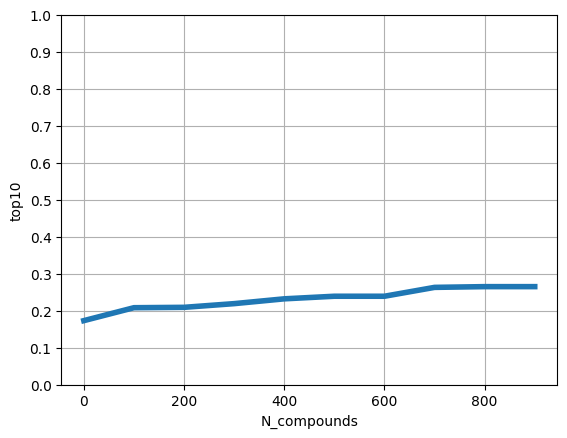

In [33]:
# 6. plot metrics using matplotlib
plt.plot([i*100 for i in range(len(metrics))],
          [m['top10'] for m in metrics], linewidth=4)
plt.grid()
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('N_compounds')
plt.ylabel('top10')
plt.show()

In [34]:
# 7. This assert should work now!
assert metrics[-1]['top10'] > 0.25 # should match baseline-random on GSK

# Chapter 2: Go Beyond Known Compounds with Mutation

### 📝 Optimize the discovery process

Our initial screening campaign produced some positive results, but unfortunately, your manager is not satisfied with the cost-to-success ratio. A lot of money was spent on buying compounds and running biochemical assays, but only a few new compounds were found. It is crucial to optimize this process before the company runs out of funding. One possible solution is to use the already tested compounds to build a QSAR model that can aid in your search. Additionally, you can consider modifying the existing compounds to find similar compounds with better activity.

### 📘 Glossary

*Biochemical assay* - a test or an analytical procedure that measures protein binding or activity.

*ChEMBL* - a public database of molecule activity sourced from publications and patents.

*Molecular fingerprint* - a binary vector that encodes fragments that are included in the molecule; the fragments can be predefined or extracted automatically, e.g. by enumerating substructures around each atom of the molecule.

*Molecular graph* - a graph representation of a molecule, in which atoms are nodes and chemical bonds are edges, attributed with atom features that encode atom types (carbon, oxygen, nitrogen, etc.) and other atomic properties.

*QSAR* - quantitative structure-activity relationship; the name used to describe machine-learning models that predict activity based on the chemical structures at the input.

*Random forest* - a machine-learning model that produces its predictions by combining predictions of multiple decision trees constructed based on the input data; single decision trees perform a sequence of decisions on the input features to maximally separate different data classes (in our case, molecules with different activity labels).

*SELFIES* - a string representation of a molecule that was designed to work better with machine learning algorithms, e.g. by simplifying the grammar of possible molecules compared to SMILES strings and reducing the number of invalid structures.

*SMILES* - a string representation of a molecule that is commonly used to store chemical formulas in databases; in this representation, all atoms of the molecule are encoded by traversing the molecular graph using the DFS order.

### ⚒️ Exercise 2: Achieve >40% on GSK by exploring mutated compounds

<image of zombie>

Now we need to introduce a method that can optimize our molecules by introducing small structure modifications. We will use the SELFIES representation of molecules (linearized textual representation) that can be easily modified by changing some letters in the representation code. For example, we can change atoms by replacing their symbols in the SELFIES string. We can also add more atoms by adding symbols in the middle of the sequence.


<img src="https://github.com/molecule-one/mlinpl-23-workshops/blob/main/assets/lab4.png?raw=true" width="400px" />

In [53]:
from selfies import encoder, decoder
import numpy as np
from src.mutate import mutate_selfie
from src.al_loop import LeadCompound
from src.organic import evaluate_synthesizability
from src.sas_score import compute_ertl_score

In [335]:
# found max activity
all_random_molecules = sum([loop.load(iteration_id=i) for i in range(loop.n_iterations)], [])
print(f'Max activity: {max([m.activity for m in all_random_molecules])}')

Max activity: 0.55


In [342]:
mutate_top_k = 10
n_candidates = 100

all_random_molecules = sum([loop.load(iteration_id=i) for i in range(loop.n_iterations)], [])
smiles = list(sorted(all_random_molecules, key = lambda m: (-m.activity, -m.synth_score)))
selfies = [encoder(m.smiles) for m in smiles[:mutate_top_k]]

new_compounds = []
while len(set(new_compounds)) < n_candidates:
    for selfie in selfies:
        new_selfie = decoder(mutate_selfie(selfie, max_molecules_len=100)[0])
        if compute_ertl_score(new_selfie) > 0. and compute_ertl_score(new_selfie) < 4.:
            new_compounds.append(new_selfie)
        if len(set(new_compounds)) == n_candidates:
            break

new_compounds = set(new_compounds)
assert len(new_compounds) == n_candidates

loop = Loop(base_dir=".", user_token=YOUR_TOKEN, target="GSK3β_server")
client = FlaskAppClient(base_url=SERVER_URL)

tested_molecules = loop.test_in_lab_and_save([LeadCompound(smiles=s) for s in set(new_compounds)], client=client)
show_molecules(tested_molecules)

[22:33:46] Saving results to ..                                                                       ]8;id=401167;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=68263;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#44\44]8;;\

[22:33:53] Saving results to 14.json.                                                                ]8;id=824128;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=317849;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

MolGridWidget()

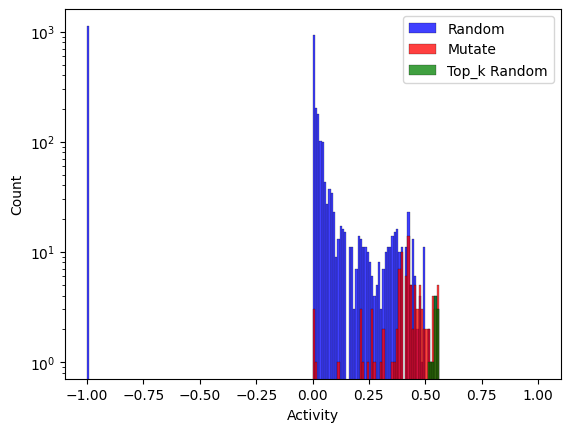

In [343]:
# 3. Show the summary of the screening results

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

data = pd.DataFrame({'Activity': [mol.activity for mol in all_random_molecules]})
sns.histplot(data, binrange=(-1, 1), binwidth=0.01, x='Activity', log=True, color="blue", label="Random") # -1 corresponds to nonsynthesizable compounds

data2 = pd.DataFrame({'Activity': [mol.activity for mol in tested_molecules ]})
sns.histplot(data2, binrange=(-1, 1), binwidth=0.01, x='Activity', log=True, color="red", label="Mutate") # -1 corresponds to nonsynthesizable compounds

data3 = pd.DataFrame({'Activity': [mol.activity for mol in smiles[:mutate_top_k]]})
sns.histplot(data3, binrange=(-1, 1), binwidth=0.01, x='Activity', log=True, color="green", label="Top_k Random") # -1 corresponds to nonsynthesizable compounds


plt.legend()
plt.show()

In [344]:
# 4. Implement mutation loop

class MutateLoop(Loop):
    """Implementation of AL algorithm that mutates top compounds from the previous iterations.

       Mutate loop should first search random and then mutate top compounds
    """
    def __init__(self, base_dir: Path, n_warmup_iterations: int = 1, mutate_top_k: int = 10, user_token=None, target="DRD2"):
        self.space = SmallZINC()
        self.n_warmup_iterations = n_warmup_iterations
        self.mutate_top_k = mutate_top_k
        super().__init__(base_dir, user_token, target)

    def _propose_random(self, n_candidates: int) -> List[LeadCompound]:
        smi = [self.space.try_sample()[0] for _ in range(n_candidates)]
        return [
            LeadCompound(s, None, None) for s in smi
        ]

    def propose_candidates(self, n_candidates: int) -> List[LeadCompound]:

        if n_candidates < self.mutate_top_k:
            raise ValueError(f"n_candidates must be at least mutate_top_k ({self.mutate_top_k}).")

        if n_candidates == 0:
            return []

        if self.n_iterations < self.n_warmup_iterations:
            return self._propose_random(n_candidates)

        ### START SOLUTION
        previous_results: List[LeadCompound] = self.load()

        candidates = list(sorted(previous_results, key = lambda m: (-m.activity, -m.synth_score)))
        selfies = [encoder(m.smiles) for m in candidates[:self.mutate_top_k]]

        new_compounds = []
        while len(set(new_compounds)) < n_candidates:
            for selfie in selfies:
                new_selfie = decoder(mutate_selfie(selfie, max_molecules_len=100)[0])
                if compute_ertl_score(new_selfie) > 0. and compute_ertl_score(new_selfie) < 4.:
                    new_compounds.append(new_selfie)
                if len(set(new_compounds)) == n_candidates:
                    break

        new_compounds = set(new_compounds)
        #### END SOLUTION

        assert len(new_compounds) == n_candidates
        return [LeadCompound(smiles=c) for c in new_compounds]

In [345]:
# 5. Run mutation loop
mloop = MutateLoop(base_dir="mutate", user_token=YOUR_TOKEN, target="GSK3β_server")
mutate_metrics = run(mloop, purge=True, budget=1000, steps=10)

Found local copy...
Loading...
Done!


[22:34:53] Saving results to mutate.                                                                  ]8;id=507286;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=752167;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#44\44]8;;\

Step 0

[22:35:01] Saving results to mutate\0.json.                                                          ]8;id=761451;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=501615;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mutate\visualize_0.html for 100 compounds from iteration 0.        ]8;id=298615;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=631027;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['CCOc1ccc(CCC(=O)N2CCc3ccc(Cl)cc3C2)cc1', 'Cc1ccc(Oc2ccc(N)c(C(F)(F)F)c2)cc1C', 'O=C(Cc1ccc(CNC(=O)c2cnc3c(c2)NC(=O)CO3)cc1)Nc1ccccc1F', 'CCn1cc(C(=O)Nc2cc(C)nn2-c2ccccc2C(F)(F)F)cn1', 'Cc1ccc(C(=O)N(C)[C@@H](C)c2cccnc2)c(C)n1', 'Cc1ccc(-c2ccc(-c3ccn[nH]3)cc2)c(N)[nH+]1', 'CC[C@@H](C)n1ncc2c(C(=O)N3CCC(c4noc(C)n4)CC3)cc(C)nc21', 'CC(=O)N1C=Cc2ccccc2[C@@H]1CC(=O)N1CCN(S(=O)(=O)c2ccc(C)cc2)CC1', 'Cc1cnn(C)c1C(=O)/N=c1/sc2c(C)ccc(C)c2n1C', 'O=S(=O)(c1ccc(F)cc1F)N1CCC(O)(C(F)(F)F)CC1', 'Cc1cccc(CN(C2CC2)S(=O)(=O)c2ccc3c(c2)C(=O)N(C)C3=O)c1', 'CCn1cnnc1CNC(=O)c1cccc(F)c1Cl', 'Cc1c(C#N)c2ccccc2n1CC(=O)N1CC[C@H](O)C[C@@H]1C(=O)[O-]', 'O=C(NNC(=O)c1cc(F)cc(F)c1)c1cccc(O)c1', 'O=C(NNC(=O)[C@H]1[C@@H](C(=O)[O-])[C@H]2CC[C@@H]1C2)c1cccc(Cl)c1', 'C[C@@H](NC(=O)CN(C)c1ccccc1)c1ccccc1Cl', 'CC[C@@H](O)CN(Cc1cccc(C(=O)N(C)C)c1)c1ccccc1', 'Cc1ccccc1CN1CC[NH+](CC(=O)Nc2cccc3nonc23)CC1', '[O-]C1=NC(=S)S/C1=C\\c1ccc(CSC(F)F)o1', 'O=C(c1cn(C2CCN(S(=O)(=O)c3c(F)cccc3F)CC2)nn1)N1CCCCC1', 'COCC[NH+]1CCc2nc(S

MolGridWidget()

Step 1

[22:35:11] Saving results to mutate\1.json.                                                          ]8;id=797932;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=696334;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mutate\visualize_1.html for 100 compounds from iteration 1.        ]8;id=768644;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=101283;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['C1C=CC=C(C2=CC=C(C3=CC=N[NH1]3)C=C2)C(N)=[NH1+1]1', 'O=C(NC[C@H1]1CC2=CC=CC(C3=CN=CN=C3)=C2O1)C(C=CC=C(C)Cl)C', 'CC=CC=CC[H]', 'O=C(NC#B)CC1(C2=CC=C(Cl)C=C2)CC1', 'CCCOCC(=O)N(C)CC=C(C=CCCl)[NH1]N', 'C[C@H1](NC=CC=O)C1=CC=CC=C1', 'CC1=CC=C(C2=CC=C(C3=CC=N[NH1]3)C=C2)C(N)=[NH1+1]1', 'CCCC1=CC=C([C@H1]2C(C#N)=C(N)OC3=N[NH1]C([C-1])=C32)S1', 'CCCC1=CC=C([C@H1]2C(C#N)=C(N)OC3=N[NH1]C(C)=C32)S1', 'C=CC1=NC=NC(NC2=CC(Cl)=CC(Cl)=C2)=C1N', 'C[C@H1](CC(=O)/C=C1/SC2=CC=CC=C2NC1=O)C3=CC=CC=C3', '[N-1]C[C@H1](NC(=O)/C=C1/SC2=CC=CC=C2NC1=O)C3=CC=CC=C3', 'C[C@H1](NC(=O)/C=C1/SC2=CC=CC=C2NC1=O)C=CC=C', 'O=C(NC[C@H1]CC1=CC=CC(C2=CN=CN=C23)=C1O3)CC4(C5=CC=C(Cl)C=C5)CC4', 'CCCOCC(=O)NC(C1=CC=C(OC)C=C1)[NH1]N', 'CCCC1=CC=C([C@H1]2C(C=S)=C(N)OC3=N[NH1]C(C)=C32)S1', '[N+1]=C(NC[C@H1]1CC2=CC=CC(C3=CN=CN=C3)=C2O1)C4(C5=CC=C(Cl)C=C5)CC4', 'COC=CC1=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCC[O+1]S)C=C1OC', 'CC[C-1]OC1=NC=NC(NC2=CC(Cl)=CC(Cl)=C2)=C1N', 'COC1=CC=C(C(=[N+1])C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)

MolGridWidget()

Step 2

[22:35:21] Saving results to mutate\2.json.                                                          ]8;id=447732;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=820420;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mutate\visualize_2.html for 100 compounds from iteration 2.        ]8;id=617351;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=426329;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['NC1=CC=C(C2=C(F)C=C(F)CC2F)C=N1', 'COC1=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=[B-1])C=C1OC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1[S-1])CCCl)C=COC', 'NC1=CC=C(C2=C(F)C=C(F)[O+1]=C2F)C=N1', 'COC=CC=C(C(=O)CSC1=NC=C(C(C2=CC=NC=C2)=C1CBr)NCC)Cl', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)NCC)Cl', 'COC=CC1=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2)NCCCC[O+1]S)C=C1OC', 'C=[C+1]CCOC1=NC=NC(NC2=CC(Cl)=CC(Cl)=C2)=C1I', 'COC1=CC=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCC[B-1]4)C=C1O[C+1]C', 'NC=CC=C(C1=C(F)C=C(F)C=C1O)F', 'CCCCl', 'NC1=CC=C(C2=C(F)C=C([O+1])C=C2F)C=N1', 'COC=CC1=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCC[O+1]S)C=C1OC', 'NC=CCC1=C(F)C=C(F)C=C1F', 'C=[C-1]CC=C(C1=CC=C(C2=CC=N[NH1]2)C=C1)C(N)=[NH1+1]', 'NC1=CC=C(C2=C(F)C=C(F)C=C2F)[P-1]=N1', 'C1OC=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=21)C)Cl', 'CBr', 'NC1=CC=C(C2=[N+1](F)C=C(F)C=C2F)C=N1', 'COC[B-1]=CC=C(C(=O)C=1SC2=NC3=C(C(C4=CC=NC=C4)=C2C=1N)CCCC3)C=COC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC

MolGridWidget()

Step 3

[22:35:31] Saving results to mutate\3.json.                                                          ]8;id=36;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=120941;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mutate\visualize_3.html for 100 compounds from iteration 3.        ]8;id=81606;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=334754;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['OC=CC=CC(=O)C=1SC2=NC=CC(C3=CC=NC=C3)=C2C=1NCCCl', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1)NNC)CCl', 'COC=[S+1]C=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)NCC)Cl', 'COC1=CC=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2)NCCC[B-1]4)C=C1OCS', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NN=C3)=C2C=1N)CCCl)C=COC', 'COC1=CC=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCC[B-1]4)C=C1', 'COC=CCCl', 'OC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1[C-1])CCCl)C=COC', 'C1OC=CC=C(C(=O)C1=NC=C(C(C2=CC=NC=C2)=CCN)CC)Cl', 'COC=CC=CCOC=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCCl', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)NCC)Cl', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCCl)CCOC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCCF)SCBr', 'NOC1=CC=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCC[B-1]4)C=C1OCS', 'OC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCCl)C=C', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)NCC)[P-1]', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)C[P+1]C)Cl', 'COC=C1C=C(C(

MolGridWidget()

Step 4

[22:35:41] Saving results to mutate\4.json.                                                          ]8;id=894545;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=318884;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mutate\visualize_4.html for 100 compounds from iteration 4.        ]8;id=515446;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=495927;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['COC=CC=CC(=O)C=1SC2=NC=CC(C3=CC=NC=C3)=C2C=1NN', 'COC=CC=C(CN(O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC)F', 'COC=CC=C(C=[N+1])C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCCl', 'COC=CC=C(C(=O)C=1NC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC=O)C=CCOC', 'COC=CC=C(CC(=O)NC=1SC2=NC=CC(C3=CC=NC=C3)=C2C=1N)CBCl', 'COC=NCC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC=O)C=CCOC', 'COC=CC=CC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)N=S', 'COC=CC=CC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1)NN', 'COC=PC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC=O)C=CCOC', 'COC=CC=CC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)N=P', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCCF)SCC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC)COC', 'COC=CC=CC(=[N+1])C=1SC2=NC=CC(C3=CC=NC=C3)=C2C=1NCCCl', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC)OC=CCOC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCCF)SOC', 'COC=CC(O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)N', 'COC=CC=CC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCCF', 'COC=CC=CC(=O)C=1SC2=N

MolGridWidget()

Step 5

[22:35:51] Saving results to mutate\5.json.                                                          ]8;id=316916;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=214793;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mutate\visualize_5.html for 100 compounds from iteration 5.        ]8;id=117323;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=324142;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['COC=CCB=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)[H])C=COCS', 'COCNC=CC(=O)C=1SC2=NC=CC(C3=CC=NC=C3)=C2C=1N[H]', 'COCl', 'C(C)=CC=CC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)N', 'C1OC=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)[H])[O+1]=C1CS', 'C1=[O+1]C=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)[H])C=C1OCS', 'C1OC=CC=C(C(=O)CSC2=NC=C(C(C3=CC=NC=C3)=C2CN)[H])[O+1]=C1OCS', 'COC=CC=CC(=O)CSC1=NC=C(C(C2=CC=NC=C2)=C1CC)N[B+1]N', 'P=[B-1]C=CC=CC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)N', 'COC=CC=C(CN(O)C=1SC2=NC=CC(C3=CC=NC=C3)=C2C=1N)[H]', 'C1OCNC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)[H])C=C1OC', 'COC=CC=C(C(=O)C=1SC2=NC=CC(C3=CC=NC=C3)=C2C=1N)[H]', 'COCNC=C(C(=[B-1])OC=1SC2=NC=CC(C3=CC=NC=C3)=C2C=1N)[H]', 'COC=CC=C(C(=O)BC=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1)N)[H]', 'C1OC=C1', 'C1OC=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)[H])[O+1]=C1OC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)[H])[N+1]COCS', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC[S-1])CCl', 'COC=CC=C(C(=O)C=1SC2=

MolGridWidget()

Step 6

[22:36:01] Saving results to mutate\6.json.                                                          ]8;id=748022;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=920361;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mutate\visualize_6.html for 100 compounds from iteration 6.        ]8;id=464420;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=363431;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['COC=CC=C(C(=O)C[C+1]=1SC2=NC=CC(C3=CC=NC=C3)=C2C=1N)[H]', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)[H])[N+1]F', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)[H])C=CCS', 'COC=CC=C(C(=O)C[B-1]=1SC2=NC=CC(C3=CC=NC=C3)=C2C=1N)[H]', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1)N[H])C#CCS', 'COC=CC=C(C(=O)C=1SC2=NC=CC(C3=CC=NC=C3)=C2C=1)N[H]', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1[B-1])N)[H]', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)[H])[B-1]COCS', 'C1OC=CC1C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)[H]', 'COC=CC=C(C(=O)C=1SC2=NC=CC(C3=CC=NC=C3)=C2C=1N)[H]', 'COC=CC=CC(=O)CSC1=NC=CC(C2=CC=NC=C2)=C1CN[H]', 'O1C=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)[H])[O+1]=C1OC#S', 'COC=CC=C(C(=O)C=1SC2=NC=CC(C3=CC=NC=C3)=C2C=1N[H])S', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1)N[H])CCCS', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)[H])[N+1]COCS', 'C1OC=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)[H])[C+1]1OCS', 'OC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N

MolGridWidget()

Step 7

[22:36:12] Saving results to mutate\7.json.                                                          ]8;id=251024;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=867642;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mutate\visualize_7.html for 100 compounds from iteration 7.        ]8;id=118880;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=810456;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['O1C=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)[H])[O+1]=C1CS', 'COC=CC=C(C(=O)C[C+1]=1SC2=NC=CC(C3=CC=NC=C3)=C2C=1N)[H]', 'O1C=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)[H])[O+1]1', 'COC=CC=C(C(=O)CSC1=NC=C(C(C2=CC=NC=C23)=C13)N)[H]', 'CC=CC#CC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)[H]', 'C1OC=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)[H])[O+1]=C1CS', 'CO[N+1]C=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)[H])COCS', 'FOC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)[H])COCS', 'O1C=C1', 'COC=CC=C(C(=O)C=1SC2=NC=CC(C3=CC=NC=C3)=C2C=1N)[H]', 'OC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)[H])[O+1]=C=O', 'OC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)[N+1])[H]', 'CC1=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)[H])[O+1]=S=C1OCS', 'OCBr', 'COC=C=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)[H])COCS', 'C1OC=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)[H])[O+1]=C1SCS', 'O1C=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)[H])[O+1]=C1OS', 'COC=CC=C(C(=O)CSC1=NC=C(C(C2=CC=NC=C2)=C1CI)N)[H]', 

MolGridWidget()

Step 8

[22:36:24] Saving results to mutate\8.json.                                                          ]8;id=844636;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=724947;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mutate\visualize_8.html for 100 compounds from iteration 8.        ]8;id=394616;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=529788;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['COC=CC=C(C(=B)OC=1SC2=NC=CC(C3=CC=NC=C3)=C2C=1N)[H]', 'COC=CC=C(C(=O)C=1SC2=NC=CC(C3=CC=NC=C3)=C2C=1N)CS', 'C1OC=CC=C(C(=O)C=2SC3=NC=CC(C4=CC=NC=C4)=C3C=2N)[O+1]=C1OC[O-1]', 'C1CC=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)[H])C1OCS', 'COC=CC=C(C(=O)CSC1=NC=C(C(C2=CC=NC=C2)=C1CCl)N)[H]', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)[H])[O+1]COCS', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1S)N)[H]', 'C1OC=CC=C(C(=O)CSC2=NC=C(C(C3=CC=NC=C3)=C2CN)[H])[O+1]=C1OCS', 'C1OC=CC=C(C(=O)C=2SC3=NC=CC(C4=CC=NC=C4)=C3C=2N)[C+1]=C1OCS', 'C1OC=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)[H])C1=[C-1]CS', 'C1OC=CC=C(C(=O)C1=NC=CC(C2=CC=NC=C2)=CCN)[H]', 'C1OC=CC1C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)[H]', 'COC=CC=C(C(=O)C=1SC2=NC=CC(C3=CC=NC=C3)=C2C=1N)[H]', 'C1OC=C1', 'C1OC=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)[H])B1OCS', 'C1OC=CC=C(C(=O)C=2SC3=NC=CC(C4=CC=NC=C4)=C3C=2[H])[O+1]=C1OCS', 'COC=CC=C(C(=O)CC1=NC=CC(C2=CC=NC=C2)=C1CN)[H]', 'COSC=CC=C(C(=O)C=1SC2=NC=CC(C3=CC=NC=C3)=C2C=1N)

MolGridWidget()

Step 9

[22:36:35] Saving results to mutate\9.json.                                                          ]8;id=482919;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=288066;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mutate\visualize_9.html for 100 compounds from iteration 9.        ]8;id=674410;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=392457;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['C1OC=CC=C(C(=O)C=2SC3=NC=CC(C4=CC=NC=C4)=C3C=2N)[O+1]=C1OC', 'S1OC=CC=C(C(=O)C=2SC3=NC=CC(C4=CC=NC=C4)=C3C=2N)[O+1]=C1OCS', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1S)N)[H]', 'COC=CC=C(C(=O)CC=1SC2=NC=CC(C3=CC=NC=C3)=C2C=1N)[H]', 'COC=CCC=C(C(=O)C=1SC2=NC=CC(C3=CC=NC=C3)=C2C=1N)COCCS', 'C1OC=CC=C(C(=O)CSC2=NC=C(C(C3=CC=NC=C3)=C2CN)[H])[O+1]=C1OCS', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1[B-1])N)[H]', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)[H])[O+1]=C[N-1]', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1[B+1])N)[H]', 'COC=CC=C(C(=O)[C-1]C=1SC2=NC=CC(C3=CC=NC=C3)=C2C=1N)[H]', 'COC=CC=C(C(=O)C=1SC2=NC=CC(C3=CC=NC=C3)=C2C=1N)[H]', 'COC=CC=C(C(=O)C=1SC2=NC=CC(C3=CC=NC=C3)=C2C=1N)COCCS', 'COC=CC=C(C(=O)C=1SC2=NC=CC(C3=CC=NC=C3)=C2C=1N[H])S', 'C1OC=C1', 'C1OC=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)[H])[O+1]=C1OC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)[H])[O+1]=C=[N-1]', 'COC=CC=C(C(=O)CC1=NC=CC(C2=CC=NC=C2)=C1CN)[H]', 'C1OC=CC=C(C(=O)CSC2=NC=C(C(C3=

MolGridWidget()

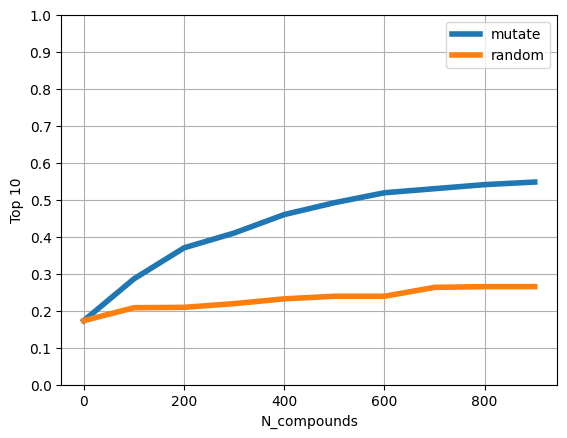

In [346]:
# 5. Plot metrics using matplotlib
plt.plot([i*100 for i in range(len(mutate_metrics))],
          [m['top10'] for m in mutate_metrics], linewidth=4, label="mutate")
plt.plot([i*100 for i in range(len(metrics))],
          [m['top10'] for m in metrics], linewidth=4, label="random")
plt.legend()
plt.grid()
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('N_compounds')
plt.ylabel("Top 10")
plt.show()

In [347]:
mutate_metrics

[{'top10': 0.173, 'top10_synth': 2.7540767857860793},
 {'top10': 0.286, 'top10_synth': 3.28506190844881},
 {'top10': 0.37, 'top10_synth': 3.6905347031735616},
 {'top10': 0.41, 'top10_synth': 3.7021948598188787},
 {'top10': 0.45999999999999996, 'top10_synth': 3.804307726449695},
 {'top10': 0.492, 'top10_synth': 3.8138722928718467},
 {'top10': 0.519, 'top10_synth': 3.878822822451494},
 {'top10': 0.53, 'top10_synth': 3.8940276690298945},
 {'top10': 0.541, 'top10_synth': 3.894788150687474},
 {'top10': 0.548, 'top10_synth': 3.8798534703714025}]

In [349]:
# 7. This assert should work now!
assert mutate_metrics[-1]['top10'] > 0.3 # should match baseline-random on GSK

In [ ]:
# 8. Check your performance on leaderboard. Do you see score > 0.4?

### 📝 Report your new findings

Congratulations! You found several novel molecules that are very promising! Now, you need to convince the stakeholders that your approach is highly efficient. Let's compare our new hits with random molecules sampled from ZINC

In [350]:
# 9. Compare random and mutate. What do you observe?

top100_random = list(sorted(sum([loop.load(iteration_id=i) for i in range(loop.n_iterations)], []), key=lambda k: -k.activity))[0:100]
show_molecules(top100_random)

MolGridWidget()

In [351]:
top100_mutate = list(sorted(sum([mloop.load(iteration_id=i) for i in range(mloop.n_iterations)], []), key=lambda k: -k.activity))[0:100]
show_molecules(top100_mutate)

MolGridWidget()

In [352]:
# Examine the worst 100 compounds. These have assigned -1 activity, which are not synthesizable according to the laboratory
bottom100_mutate = list(sorted(sum([mloop.load(iteration_id=i) for i in range(mloop.n_iterations)], []), key=lambda k: k.activity))[0:100]
show_molecules(bottom100_mutate)

MolGridWidget()

In [353]:
# You can compute synthesizabiltiy before sending to the lab!
from src.sas_score import compute_ertl_score
print(compute_ertl_score(bottom100_mutate[0].smiles))
print(compute_ertl_score(top100_mutate[0].smiles))

4.347981516281701
3.8782583281146312


### ⚒️ Exercise 3: Tune the warmup.

Is is better to use longer or smaller warmup?

Found local copy...
Loading...
Done!


[22:39:07] Saving results to mutate.                                                                  ]8;id=699135;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=399008;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#44\44]8;;\

Step 0

[22:39:15] Saving results to mutate\0.json.                                                          ]8;id=973390;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=582154;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mutate\visualize_0.html for 100 compounds from iteration 0.        ]8;id=344849;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=188262;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['CCOc1ccc(CCC(=O)N2CCc3ccc(Cl)cc3C2)cc1', 'Cc1ccc(Oc2ccc(N)c(C(F)(F)F)c2)cc1C', 'O=C(Cc1ccc(CNC(=O)c2cnc3c(c2)NC(=O)CO3)cc1)Nc1ccccc1F', 'CCn1cc(C(=O)Nc2cc(C)nn2-c2ccccc2C(F)(F)F)cn1', 'Cc1ccc(C(=O)N(C)[C@@H](C)c2cccnc2)c(C)n1', 'Cc1ccc(-c2ccc(-c3ccn[nH]3)cc2)c(N)[nH+]1', 'CC[C@@H](C)n1ncc2c(C(=O)N3CCC(c4noc(C)n4)CC3)cc(C)nc21', 'CC(=O)N1C=Cc2ccccc2[C@@H]1CC(=O)N1CCN(S(=O)(=O)c2ccc(C)cc2)CC1', 'Cc1cnn(C)c1C(=O)/N=c1/sc2c(C)ccc(C)c2n1C', 'O=S(=O)(c1ccc(F)cc1F)N1CCC(O)(C(F)(F)F)CC1', 'Cc1cccc(CN(C2CC2)S(=O)(=O)c2ccc3c(c2)C(=O)N(C)C3=O)c1', 'CCn1cnnc1CNC(=O)c1cccc(F)c1Cl', 'Cc1c(C#N)c2ccccc2n1CC(=O)N1CC[C@H](O)C[C@@H]1C(=O)[O-]', 'O=C(NNC(=O)c1cc(F)cc(F)c1)c1cccc(O)c1', 'O=C(NNC(=O)[C@H]1[C@@H](C(=O)[O-])[C@H]2CC[C@@H]1C2)c1cccc(Cl)c1', 'C[C@@H](NC(=O)CN(C)c1ccccc1)c1ccccc1Cl', 'CC[C@@H](O)CN(Cc1cccc(C(=O)N(C)C)c1)c1ccccc1', 'Cc1ccccc1CN1CC[NH+](CC(=O)Nc2cccc3nonc23)CC1', '[O-]C1=NC(=S)S/C1=C\\c1ccc(CSC(F)F)o1', 'O=C(c1cn(C2CCN(S(=O)(=O)c3c(F)cccc3F)CC2)nn1)N1CCCCC1', 'COCC[NH+]1CCc2nc(S

MolGridWidget()

Step 1

[22:39:24] Saving results to mutate\1.json.                                                          ]8;id=497007;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=722898;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mutate\visualize_1.html for 100 compounds from iteration 1.        ]8;id=687009;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=559604;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['CCC1=CC=C(C2=CC=C(C3=CC=N[NH1]3)C=C2)C(N)=[NH1+1]1', 'COC1=CC=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC=C', 'CCC1=CC=C([C@H1]2C(C#N)=C(N)OC3=N[NH1]C(C)=C32)S1', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC#N)C=COC', 'C12C=CC=C(C3=CC=C(C4=CC=N[NH1]4)C=C3)C1=[NH1+1]2', 'PCOC1=CC(/C=N/N=C2/NC(=O)[C@@H1](CC(=O)C3=CC=C(C)C(C)=C3)S2)=CC=C1O', 'CC1=CC=C(C2=CC=C(C3=CC=N[NH1]3)C=C2)C(N)=[NH1+1]1', 'O1C2=CN=CN=C2C1O', 'CCCC1=CC=C([C@H1]2C(C#N)=C(N)OC3=N[NH1]C(C)=C32)S1', 'COC1=CC=C(C(=O)C=2SC3=N[B-1]4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'CCCOCC(=O)N(P)CC=1C=C(C2=CC=C(OC)C=C2)[NH1]N=1', 'CCCOC1=NC[S-1]C(NC2=CC(Cl)=CC(Cl)=C2)=C1N', 'O=C(N=[P+1][C@H1]1CC2=CC=CC(C3=CN=CN=C3)=C2O1)C4(C5=CC=C(Cl)C=C5)CC4', 'COC1=CC(/C=N/N=C2/NC(=O)[C@@H1](CC(=O)C3=CC=C(C)C(C)=C3)S2)=CC=C1OC', 'CCCOCC(=O)N(C)CC=C(C1=CC=C(OC)C=C1)[NH1]N', 'CCCOC=NC=NC(NCC1=CC(Cl)=CC(Cl)=C1)=CN', 'CCCOC#CC(=O)N(C)C=1C=C(C2=CC=C(OC)C=C2)[NH1]N=1', 'C[C@H1](NC=BC=O)C1=CC=CC=C1', 'NC1=CC=C(C2=C(F)C=C([O+1])C=C2F)C=N

MolGridWidget()

Step 2

[22:39:34] Saving results to mutate\2.json.                                                          ]8;id=463196;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=811353;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mutate\visualize_2.html for 100 compounds from iteration 2.        ]8;id=715510;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=103361;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC=C)OC', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CC)C=CSC=C1OC', 'COC=C1C=C(C(=O)CSC2=NC=C(C(C3=CC=NC=C3)=C2CC)NCCCC)C=C1O', 'CCC1=CC=C(C2=CC=C(C3=CC=N[NH1]3)C=C2)C(N)=[NH1+1]1', 'COC=CC=C(C(=O)CSC1=NC=C(C(C2=CC=NC=C2)=C1CC)NCCCC)C=CI', 'COC=C1C=C(C(=[S-1])OC=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1OC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC#N)C=COC', 'NC1=CC=C(C2=C(F)C=C([B-1])C=C2F)C=N1', '[S-1]NC1=CC=C(C2=C(F)C=C([O+1])C=C2F)C=N1', 'NC1=CC=C(C2=C(F)[C+1]=C(F)C=C2F)C=N1', 'COC=CC1=C(C(=[S-1])OC=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCCO)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)SC=C1OC#C', '[O-1]C(C[C@H1]1CC2=CC=CC(C3=CN=CN=C3)=C2O1)C4(C5=CC=C(Cl)C=C5)CC4', 'COC=CC1=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCC)CSC=C1OC', 'COC=CC=C(C(=O)CSC1=NC=C(C(C2=CC=NC=C23)=C13)NCC)NC=COC', 'COCC=C1C=C(C(=O)CSC2=NC=C(C(C3=CC=NC=C3)=C2CC)NCCCC)C=C1OC', 'COC=CC1=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CC

MolGridWidget()

Step 3

[22:39:45] Saving results to mutate\3.json.                                                          ]8;id=275903;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=155011;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mutate\visualize_3.html for 100 compounds from iteration 3.        ]8;id=571325;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=178491;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CC)C=CSC=C1OC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC=C)OC', 'BOC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC#N)C=COC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC#N)C=COC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC)NC=S=COC', 'OC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CC)C=CSC=C1OC', 'COC=CC=C(C(=[S-1])C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC=C)OC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)[B-1]CC)COC', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)SC=C1OC#C', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)NCC)NC#[C-1]', 'COCSC1=C(C(=[S-1])OC=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)SC=C1OC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1)NCC)NC=COC', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CC)C=CSC=C1[N+1]C', 'C1OC=CC=C1C(=[S-1])OCSC2=NC=C(C(C3=CC=NC=C3)=C2)CCCC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC)COC', 'C1OC=C1', 'CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=

MolGridWidget()

Step 4

[22:39:55] Saving results to mutate\4.json.                                                          ]8;id=799246;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=477408;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mutate\visualize_4.html for 100 compounds from iteration 4.        ]8;id=381192;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=858271;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['C1=CC=C1C(=[S-1])OC=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCC[H]', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)C[O-1])C#B', 'BOC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC#N)C=COC', 'COC=C=C=C(C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC#N)C=COC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC)N=[N-1]', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC)N[O+1]=COC', 'S1OC=CC=C1C(=[S-1])OC=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCC[H]', 'NCOC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)C)CNC=COC', 'C1OC=CC=C1C(=[S-1])OC=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2B)CCCC[H]', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1)NCC)NC=COC', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CC)C=CSC=C1[N+1]C', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC)NC#B', 'COC=CC=C(C(=O)CSC1=NC=C(C(C2=CC=NC=C2)=C1CN)C)CNC=COC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)N)CNC=COC', 'COC=CCC(=[S-1])OC=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCCS', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC)NC=C=O', 'C1OC=CC

MolGridWidget()

Step 5

[22:40:07] Saving results to mutate\5.json.                                                          ]8;id=587508;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=252255;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mutate\visualize_5.html for 100 compounds from iteration 5.        ]8;id=302475;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=963386;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['COC=CC=CCC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)NCCNCC=COC', 'BOC=CC=C(C(=O)CSC1=NC=C(C(C2=CC=NC=C2)=C1CN)CC#N)CI', 'NCOC=CC=C(C(=O)CSC1=NC=C(C(C2=CC=NC=C2)=C1F)C)CNC=COC', 'C1OC=CC=C1C(=[S-1])OCSC2=NC=C(C(C3=CC=NC=C3)=N2)CCCS', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)NCCNC=C)OC=C', 'COC1=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)Br)C=CSC=C1[N+1]C', 'NCOC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)C)CNC=COC', 'COC=CCCl', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)C[C-1])NCC', 'NCOC=CC=C(C(=O)CSC1=NC=C(C(C2=CC=NC=C2)=C1CN)C)CNC=COC', 'COC=CC=CCC(=[S-1])OC=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCCS', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)C[C-1])NC=CF', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CC)C=CSC=C1[N+1]C', 'C1OCC=C1C(=[S-1])OC=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCS', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)C[C-1])C=COC', 'COC=CC=C(C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)C[C-1])NC=COC', 'COF', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC)Cl'

MolGridWidget()

Step 6

[22:40:18] Saving results to mutate\6.json.                                                          ]8;id=806103;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=286461;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mutate\visualize_6.html for 100 compounds from iteration 6.        ]8;id=780032;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=596875;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['COC=CC=CCC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)NCCNCC=COC', 'COC=CC=C(C(=O)CSC1=NC=C(C(C2=CC=NC=C2)=C1)NN)CCNCC=CO', 'BOC=CC=C(C(=O)CSC1=NC=C(C(C2=CC=NC=C2)=C1CN)CC#N)CI', 'COC=CC=C(CC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)N)CCNCC=COC', 'BOC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1)NCC)NCI', 'COC=CC=CC(=O)CSC1=NC=CC(C2=CC=NC=C2)=C1CNCCNC=COC', 'BC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC#N)CI', 'C1OC=CC=C1C(=[N+1])NC=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCS', 'C=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1I)N)CCNC=COC', 'COC=CCCl', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1I)N)C#[C-1]', 'C1OC=CC=C1C(=[S-1])NC=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)C=O', 'BOC=CC=C(C(=O)CSC1=NC=C(C(C2=CC=NC=C2)=C1)NCC)NCI', 'C1OC=C1', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC#N)CI', 'COC=CC=C(C(=O)CSC1=NC=C(C(C2=CC=NC=C2)=C1CI)N)CCNC=COC', 'BOC=CC=CC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC#N', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)NC)CNCC=NOC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC

MolGridWidget()

Step 7

[22:40:29] Saving results to mutate\7.json.                                                          ]8;id=38401;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=736357;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mutate\visualize_7.html for 100 compounds from iteration 7.        ]8;id=685034;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=352249;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['BOC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)NC)CNCCNO', 'COC=CC=C(C(=O)NC=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1)N)NCCNCC=COC', 'COC=CC=C(C(=O)N1CSC2=NC=C(C(C3=CC=NC=C3)=C21)N)CCNCC=COC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1I)N)CCNCC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)NC)CNCCN=COOC', 'C1OC=CC=C1C(=[N+1])NC=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCS', 'COCNC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)NC)CNCC=COOC', 'COC=CCC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)NCCNCC=COOC', 'COCC=CC=CC(=[N+1])NC=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCCS', '[C-1]C=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)NC)CNCC=COC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1I)S)NCCNC=COC', 'COC=CC=C(C(=O)CSC1=NC=C(C(C2=CC=NC=C2)=C1CI)N)CCNC=COC', 'BOC=CC=CC(=O)C1=NC=C(C(C2=CC=NC=C2)=C1CN)NCCNCC=CO', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1I)N)CCNC=C', 'COC=CC=CC(=O)C=1SC=NC=CC(C2=CC=NC=C2)=CC=1I', 'B1OC=C1CC(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)NCCNCC=CO', 'COC=CC=C(C(=O)NC=1SC2=NC=C(C(C3=CC=

MolGridWidget()

Step 8

[22:40:40] Saving results to mutate\8.json.                                                          ]8;id=438103;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=679711;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mutate\visualize_8.html for 100 compounds from iteration 8.        ]8;id=542537;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=878802;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['[H]OC=CC=CC(=[P-1])NC=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCCS', 'COC=CC=C(C(=O)NC=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)[P-1])CCNCCF', 'C=CC=C(C(=O)NC=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)N)CCNCCF', 'CO[S+1]=CC=C(C(=O)NC=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)N)CCI', 'COC=CCCl', 'COCNC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)NC)CNCC=COOC', 'C=1OC=CC=C(C(=O)N=1)CCNCCF', 'COC=CC=C(C(=O)NC=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)N)CCNCC=COSC', 'COOCC=C(C(=O)NC=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)N)CCNCC=COC', 'FOC=CC=C(C(=O)NC=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)N)CCI', 'COC=CC=C(C(=O)NC=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1S)N)NCCNCCF', 'COC=CC=CCC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)NCCNCC=COOC', 'COC=CC=C(C(=O)OC=1SC2=NC=CC(C3=CC=NC=C3)=C2C=1N)NCCNCC=COOC', 'COC=CC#CC(=O)NC=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)N', 'COC=CC=C(CC=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)NCCNCC=COOC', 'C1OC=CC=C1C(=S)NC=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCS', 'COC=CC=C(C(=O)NCSC1=NC=C(C(C2=CC=NC=C2)=C1CC)N)NCCNCC=COC', 'COC=CC=C([S+1]C(=O)NC=1SC2=NC=CC(C3=

MolGridWidget()

Step 9

[22:40:51] Saving results to mutate\9.json.                                                          ]8;id=525235;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=922642;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mutate\visualize_9.html for 100 compounds from iteration 9.        ]8;id=905880;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=678303;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['COC=CCCC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)NCCNCC=COOC', 'COC=CC=C(C(=O)OC=1OC2=NC=CC(C3=CC=NC=C3)=C2C=1N)NCCNCC=COOC', 'COC=CC=C(C(=O)OC=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)N)CCNCC=C', 'C=1OC=CC=C(C=1NC=2SC3=NC=CC(C4=CC=NC=C4)=C3C=2N)NCCNCCF', 'COC=CC=C(C(=O)NC=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)[P-1])CCNCCF', 'COCl', 'C(C=CC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)NC)CNCC=COOC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1)NN)CCNCC=COOC[H]', 'COC=CC=C(CC(=O)NC=1SC2=NC=CC(C3=CC=NC=C3)=C2C=1N)NCCNCCF', 'COC=CC=C(C(=O)NC=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)N)CSCN', 'CSOC=CC=C(C(=O)NC=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)N)CCNCCF', 'OOC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)NC)CNCC=COOC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)NN)CC=COOC', 'COC=CC=CCC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)NCCNCC=COOC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)NC)C=CCC=COOC', 'COC=CC=C(C(=O)OC=1SC2=NC=CC(C3=CC=NC=C3)=C2C=1)NNCCNCC=COOC', 'COC=CC=C(C(=O)OC=1SC2=NC=CC(C3=CC=NC=C3)=C2C=1N)NCCNCC=

MolGridWidget()

Found local copy...
Loading...
Done!


[22:40:52] Saving results to mutate.                                                                  ]8;id=524707;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=899798;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#44\44]8;;\

Step 0

[22:41:01] Saving results to mutate\0.json.                                                          ]8;id=628371;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=429752;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mutate\visualize_0.html for 100 compounds from iteration 0.        ]8;id=195052;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=680216;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['CCOc1ccc(CCC(=O)N2CCc3ccc(Cl)cc3C2)cc1', 'Cc1ccc(Oc2ccc(N)c(C(F)(F)F)c2)cc1C', 'O=C(Cc1ccc(CNC(=O)c2cnc3c(c2)NC(=O)CO3)cc1)Nc1ccccc1F', 'CCn1cc(C(=O)Nc2cc(C)nn2-c2ccccc2C(F)(F)F)cn1', 'Cc1ccc(C(=O)N(C)[C@@H](C)c2cccnc2)c(C)n1', 'Cc1ccc(-c2ccc(-c3ccn[nH]3)cc2)c(N)[nH+]1', 'CC[C@@H](C)n1ncc2c(C(=O)N3CCC(c4noc(C)n4)CC3)cc(C)nc21', 'CC(=O)N1C=Cc2ccccc2[C@@H]1CC(=O)N1CCN(S(=O)(=O)c2ccc(C)cc2)CC1', 'Cc1cnn(C)c1C(=O)/N=c1/sc2c(C)ccc(C)c2n1C', 'O=S(=O)(c1ccc(F)cc1F)N1CCC(O)(C(F)(F)F)CC1', 'Cc1cccc(CN(C2CC2)S(=O)(=O)c2ccc3c(c2)C(=O)N(C)C3=O)c1', 'CCn1cnnc1CNC(=O)c1cccc(F)c1Cl', 'Cc1c(C#N)c2ccccc2n1CC(=O)N1CC[C@H](O)C[C@@H]1C(=O)[O-]', 'O=C(NNC(=O)c1cc(F)cc(F)c1)c1cccc(O)c1', 'O=C(NNC(=O)[C@H]1[C@@H](C(=O)[O-])[C@H]2CC[C@@H]1C2)c1cccc(Cl)c1', 'C[C@@H](NC(=O)CN(C)c1ccccc1)c1ccccc1Cl', 'CC[C@@H](O)CN(Cc1cccc(C(=O)N(C)C)c1)c1ccccc1', 'Cc1ccccc1CN1CC[NH+](CC(=O)Nc2cccc3nonc23)CC1', '[O-]C1=NC(=S)S/C1=C\\c1ccc(CSC(F)F)o1', 'O=C(c1cn(C2CCN(S(=O)(=O)c3c(F)cccc3F)CC2)nn1)N1CCCCC1', 'COCC[NH+]1CCc2nc(S

MolGridWidget()

Step 1

[22:41:10] Saving results to mutate\1.json.                                                          ]8;id=990959;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=666465;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mutate\visualize_1.html for 100 compounds from iteration 1.        ]8;id=149079;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=942901;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['CCCCNC(=O)c1cccn(-c2ccc(NC(=O)c3ccc(C)cc3)cc2)c1=O', 'CC(=O)NC[C@H]1CCCN(C(=O)[C@@H]2CCO[C@H]2C)C1', 'COc1cc(OC)c(OC)cc1C[NH2+][C@H](C)c1ccc(Br)cc1', 'Cc1cccc(Cn2cccc(C(=O)NC[C@@H](O)c3ccccc3)c2=O)c1', 'CCc1ccc(C(=O)[C@H](C)Sc2nnc([C@H]3CCS(=O)(=O)C3)n2C)cc1', 'Oc1ccccc1C1OCCO1', 'CC(=O)Nc1cccc(NC(=O)[C@H](NC(=O)c2cccc(C)c2)C(C)C)c1', 'CSC1=C(C#N)[C@@H](c2ccco2)C(C(=O)Nc2ccccc2)=C(C)N1', 'CCOC(=O)C1(C(=O)C2CC2)CC2(CCCCC2)C1', 'CC(C)CCO[C@@H]1CCN(C(=O)c2cc(F)ccc2O)C1', 'CC[C@@H](C)NC(=O)c1ccc(NC(=O)N[C@@H]2CCCc3ccccc32)cc1', 'CC(=O)c1cccc(NC(=O)CCc2c(F)cccc2F)c1', 'Cc1[nH+]ccn1CCCNC(=O)c1cccc(Br)c1O', 'COC(=O)[C@@H]1CCCCC[C@H]1NC(=O)Nc1ccc(OC)c(C)c1', 'Cc1cc(C)n2nc(SCc3ccc(Br)cc3F)nc2n1', 'CC(C)c1ccc(NC(=O)CNc2cccc([N+](=O)[O-])c2)cc1', 'Fc1cccc(Cc2nc3ccccc3[nH]2)c1F', 'CC(C)C[C@H](NC(=O)OC(C)(C)C)/C(N)=N/O', 'C[C@H]1CCCC[C@@H]1CNC(=O)N1CCC(Oc2ccnc(C(N)=O)c2)CC1', 'CNC(=O)c1cc2cc(F)ccc2[nH]1', 'CCc1nc(C)sc1CN1C[C@@H]2CC[C@H](C1)[NH+](CC=C(C)C)C2', 'COc1ccc(N2CCN(C(=O)[C@H]3N=NC4=C3CSc

MolGridWidget()

Step 2

[22:41:19] Saving results to mutate\2.json.                                                          ]8;id=996155;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=491994;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mutate\visualize_2.html for 100 compounds from iteration 2.        ]8;id=827842;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=905855;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['CNC(=O)c1ccsc1NC(=O)Cc1ccc2ccccc2c1', 'C[C@@H](C(=O)Nc1ccccc1C#N)[NH+]1CCN(c2cccc(Cl)c2)CC1', 'COc1cc(C[NH+](C)CC(=O)NCC2CCCCC2)ccc1O', 'C[NH+](C)[C@@H]1CC[C@H](NC(=O)NCc2ccc(N3CCSCC3)cc2)C1', 'Cc1cccc(OCCn2c([C@@H](C)NC(=O)[C@H]3CCCO3)nc3ccccc32)c1C', 'CCC[C@H]1NC(=O)CCN([C@@H](C)c2c(C)noc2C)C1=O', 'COc1ccc([C@@H]2CC(=O)c3cn4nc(SCc5cccc(C)c5)nc4nc3C2)c(OC)c1', 'CC[NH2+][C@@H]([C@@H]1CCOC1)[C@@H]1CCOC2(CCCCC2)C1', 'COc1ccc(F)cc1NC(=O)[C@H]1CC(=O)N(c2ccccc2OC)C1', 'COc1ccc(NC(=O)C[C@H](c2ccccc2)n2cccc2)c(OC)c1', 'CC(C)(C)n1nccc1NC(=O)C(=O)NCC[NH+]1CCCCCC1', 'Cc1cc(C)nc(NC(=O)[C@@H]2CSc3nccc(=O)n3C2)n1', 'Cc1ccc(CC(=O)[O-])n1-c1ccc(F)cc1', 'COc1ccc(OCc2nnc(S[C@@H](C)C#N)n2-c2ccccc2)cc1', 'COc1ccc2c(c1OC)C(=O)N1[C@H](C(=O)NCCC(C)C)CS[C@H]21', 'NC(=O)c1c(NC(=O)c2ccc([N+](=O)[O-])cc2Cl)sc2c1CCCCC2', 'CCC1CCC([NH3+])(c2nnc3ccncn23)CC1', 'CCOC(=O)c1c(NC(=O)c2nnn(-c3ccc(C)cc3)c2C)sc2c1CC[C@@H](C)C2', 'O=C(Cc1ccccc1Cl)N1CCN(S(=O)(=O)c2ccc(Br)cc2Cl)CC1', 'O=C(Cn1c(=O)oc2cc(Cl)ccc21)N1CCC[C@@H]

MolGridWidget()

Step 3

[22:41:29] Saving results to mutate\3.json.                                                          ]8;id=335810;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=215571;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mutate\visualize_3.html for 100 compounds from iteration 3.        ]8;id=137542;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=551144;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['C1C=CC=C(C2=CC=C(C3=CC=N[NH1]3)C=C2)C(N)=[NH1+1]1', 'COC1=CC(/C=N/N=C2/NC(=O)[C@@H1](CC(=O)C3=CC=C(C)C(C)=C3)S2)=CC=C1O[C-1]', 'CCOC[N+1](=O)NC1=CC(C2=N[C@H1](C(=O)OC)CO2)=CC=N1', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COCCO[P+1]', 'CCC1=CC=C([C@H1]2C(C#N)=C(N)OC3=N[NH1]C(C)=C32)S1', 'COC1=CC=C(C(=O)C=2[B-1]C3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'C[C@@H1]=[B-1](O)C1=CC=C(N2CCCOCC2)C=C1O', 'O=C(N=[N+1]C[C@H1]1CC2=CC=CC(C3=CN=CN=C3)=C2O1)C4(C5=CC=C(Cl)C=C5)CC4', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1)CCCC)C=COC', 'CC1=CC=C(C2=CC=C(C3=CC=N[NH1]3)C=C2)C(N)=[NH1+1]1', 'O=C(NC[C@H1]1CC2=CC=CC(C3=CN=CN=C3)=C2O1)C(C4)=CC=C(Cl)C=C4CC', 'CCCC1=CC=C([C@H1]2C(C#N)=C(N)OC3=N[NH1]C(C)=C32)S1', 'N1C=CC=C(C2=C(F)C=C(F)C=C2F)N1', 'C1=CC=C([C@H1]2C(C#N)=C(N)OC3=N[NH1]C(C)=C32)S1', 'O=C(NC[C@H1]C1C2=CC=CC(C3=CN=CN=C3)=C2O1)CC4(C5=CC=C(Cl)C=C5)CC4', 'CC[H]', 'C=12OC=1C(C(=O)C=3SC4=NC5=C(C(C6=CC=NC=C6)=C4C=3N)CCCC5)C=C2OC', 'O=C(NC[C@H1]1CC2=CC=CC(C3=C=NCN=C3)=C2O1)C4(C5=CC=C(Cl

MolGridWidget()

Step 4

[22:41:38] Saving results to mutate\4.json.                                                          ]8;id=928022;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=842100;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mutate\visualize_4.html for 100 compounds from iteration 4.        ]8;id=951106;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=187376;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['O=S(=O)(C(=N)C=CC(C)=C)N1CCCC[C@@H1]1C2OCCO2', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)[N-1]CS)CCOC', 'COC=CC=C(C(=O)OC=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CS)CCOC', 'C1C=C(C(=O)C=2NC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'COC=C1C=C(C(=O)[S+1]C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC)CC=C1OC', 'O=S(=O)(C1=C[NH1]C2=NC=CC(C)=C12)NCCI', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CSC)[P-1]COC', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COC=C', 'COCC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC=C)C=COC', 'COC1=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)B=C1OC', 'C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CS)C=C1OC', 'CC1=C(C(=O)C[N-1]SC2=NC3=C(C(C4=CC=NC=C4)=C2CN)CCCC3)C=C1OC', 'C1OC=CC=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1[S-1]NOC', 'C1OC=C1', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCCCO)C=COC', 'C1OC=CC=C(C(=O)C=2SC3=NN=C(C(C4=CC=NC=C4)=C3C=2N)CCCC)C=C1NOC', 'C1C=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC#[P+1]', 'CC1=C(C

MolGridWidget()

Step 5

[22:41:48] Saving results to mutate\5.json.                                                          ]8;id=580201;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=428148;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mutate\visualize_5.html for 100 compounds from iteration 5.        ]8;id=362538;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=671903;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['COC=C[N+1]1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCCO)C=C1O[H]', 'CO[N+1]=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCCO)C=C1O[H]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N=NCCC[C@@H1]C3OCCO3', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)[N-1]CS)CCOC', 'O=S[NH1]C1=NC=CC(Cl)=C1', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COCCO[B-1]', 'O=S(=O)(C1=C[NH1]C2=NC=NC(Cl)=C12)N3CCCC[C@@H1]3C4OCCO4', 'O=S(=O)(C1=C[NH1]C2=NC=CC([B+1])=C12)N', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2I)CCCCO)C=C1O[H]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COCO', '[S-1]OSC1=C[NH1]C2=NC=CC(Cl)=C12', 'O=S(=O)(C1=C[NH1]C2=NC=CC(F)=C12)N3CCCC[C@@H1]3C4OCCO4', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCC=N[C@@H1]3C4OCCO4', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3C#CCCO', 'C1OC=C1', 'O=S(=O)(C=C[NH1][O-1])N1CCCC[C@@H1]1C2OCCO2', 'P=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N', 'C=[S-1]C=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCCO)C=C1O[H]', 'COC=CC1=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C

MolGridWidget()

Step 6

[22:41:58] Saving results to mutate\6.json.                                                          ]8;id=381488;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=135231;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mutate\visualize_6.html for 100 compounds from iteration 6.        ]8;id=520849;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=438102;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['CC1=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCCO)NC=C1O[H]', 'O=S(=O)(C1=C[NH1]C2=NC=NC(Cl)=C12)N3CCCC[C@@H1]3COCC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)[N-1]CS)CCOC', 'O=S(=O)C[NH1]C1=NC=CC(Cl)=C1', 'C=[S-1]C=CC1=C(C(=O)CSC2=NC=C(C(C3=CC=NC=C3)=C2CC)NCCCC)OC=C1O[H]', 'C=[S-1]C=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCCO)C=C1OO', 'O=S(=O)(C1=C[NH1]C2=NC=NC(Cl)=C12)N3CCCC[C@@H1]3C4OCCO4', 'C=[S-1]C=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2)NCCCCO)C=C1O[H]', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3N=2)CCCCO)NC=C1O[H]', 'O=S(=O)(C1)C[NH1]C2=NC=NC(Cl)=C12', 'COC=CC1=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCCO)NC[C-1]1O[H]', 'O=S(=O)(C1=C[NH1]C2=NC=NC(Cl)=C12)NC#N', '[P-1]C=[S-1]C=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCCO)C=C1O[H]', 'C1OC=CC2=C(C(=O)C=3SC4=NC=C(C(C5=CC=NC=C5)=C4C=3N)CCCCO)NC=C21', 'P=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)[N-1]', 'C=[S-1]C=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCCO)C=C1O[H]',

MolGridWidget()

Step 7

[22:42:08] Saving results to mutate\7.json.                                                          ]8;id=112636;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=259032;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mutate\visualize_7.html for 100 compounds from iteration 7.        ]8;id=614695;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=231108;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['O=S(=O)(C1=C[NH1]C2=NC=NC(Cl)=C12)N3CCCC[C@@H1]3COCC', 'SCOC=CC1=C(C(=O)C=2SC3=NC=C(C(C4=CCCC=C4)=C3C=2N)CCCCO)NC=C1O[H]', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)[N-1]CS)CCOC', 'O=S(=O)(OC1=C[NH1]C2=NC=CC(Cl)=C12)N(C3)OCCO3', 'O=S(=O)(OC1=C[NH1]C2=NC=CC(Cl)=C12)N=CCC[C@@H1]COCCF', 'O=S(=O)(P)C1=C[NH1]C2=NC=NC(Cl)=C12', 'O=S(=O)(OC1=C[NH1]C2=NC=CC(Cl)=C12)N=CCC=O', 'O=SOC1=C[NH1]C2=NC=CC(Cl)=C12', 'SCOC1=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCCO)NC=C1O[H]', 'O=S(=O)(C1=C[NH1]C2=NC=NC(Cl)=C12)NCCCC=[C@@H1]COCCO[B+1]', 'O=S(=O)(C1)C[NH1]C2=NC=NC(Cl)=C12', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)[N-1]CS)C', 'O=S(=O)(OC1=C[NH1]C2=NC=CC(Cl)=C12)N=CCC[C@@H1]=C3OCCO3', 'O=S(=O)(C[NH1]C1=NC=NC(Cl)=C1)N2CCCC[C@@H1]2COCCO[B+1]', 'C1OC=C1', 'COC=CC=CC(=O)CSC1=NC=CC(C2=CC=NC=C2)=C1CCSCCOC', 'O=S(=O)(C1=C[NH1]C2=NC=NC(Cl)=C12)N3CCCC4[C@@H1]3COC4', 'COF', 'COC=CC=CC(=O)CSC1=NC=CC(C2=CC=NC=C2)=C1C[N-1]CSCCOC', 'SCOC=C1C=C(C(=O)CSC2=NC=C(C(C3=CC=NC=C3)=C2F)CCCCO)NC=C1O[H]',

MolGridWidget()

Step 8

[22:42:18] Saving results to mutate\8.json.                                                          ]8;id=686406;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=99002;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mutate\visualize_8.html for 100 compounds from iteration 8.        ]8;id=193795;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=666186;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['O=S(=O)(C1=C[NH1]C2=NC=NC(Cl)=C12)NCCCC=[C@@H1]COC#[P-1]', 'O=S(=O)(P)C1=C[NH1]C2=NC=NC(Cl)=C12', 'O=S(=O)(C1=C[NH1]C2=NC=NC(Cl)=C12)N3CCCC[C@@H1]3CC=[B+1]', 'O=S(=O)(CCl)N1CCCC[C@@H1]1COCC#N', 'O=S(=O)(C#[O+1])N1CCCC[C@@H1]1COCC#N', 'O=S(=O)(C1=C[NH1]C2=NC=NC(Cl)=C12)N3CCCC[C@@H1]3COC#CCF', 'O=S(=O)(C1)C[NH1]C2=NC=NC(Cl)=C12', 'O=S(=O)(C1=C[NH1]C2=NC=NC(Cl)=C12)N3CCCC[C@@H1]3CO[B-1]', 'O=S(=O)(C=[N-1])N1CCCC[C@@H1]1COCCO', 'SCO[B-1]=CC1=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCCO)NC=C1O[H]', 'O=S(=O)(C1=C[NH1]C2=NC=NC(Cl)=C12)N3CCCC[C@@H1]3COC=O', 'O=S(=O)(C1=C[NH1]C2=NC=NC(Cl)=C12)OCCCC[C@@H1]COCC#N', 'O=S(=O)(NC1=C[NH1]C2=NC=NC(Cl)=C12)N3CCCC[C@@H1]3COCCF', 'O=S(=O)(C1=C[NH1]C2=NC=NC(Cl)=C12)N=CCC[C@@H1]CCCF', 'O=S(=O)(C1=C[NH1]C2=NC=NC(Cl)=C12)N3CCCC=B3', 'O=S(=O)(C1=C[NH1]C2=NC=NC(Cl)=C12)N3CCCC[C@@H1]3COCCO[C+1]', 'O=S(=O)(C1=C[NH1]C2=NC=NC(Cl)=C12)NCCCCCOCCO', 'CSCO[C-1]=CC1=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCCO)NC=C1O[H]', 'O=S(=O)(C=C[NH1]C=N)N1CCCC[C@@H1]1COCCO'

MolGridWidget()

Step 9

[22:42:27] Saving results to mutate\9.json.                                                          ]8;id=532425;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=739776;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mutate\visualize_9.html for 100 compounds from iteration 9.        ]8;id=785987;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=544132;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['O=S(=O)(F)N1CCCC[C@@H1]1COCCO', 'O=S(=O)(C1=C[NH1]C2=NC=NC(Cl)=C12)N(C)CC[C@@H1]COCC#N', 'O=S(=O)(C1=C[NH1]C2=NC=NC(Cl)=C12)NCCCC[C@@H1]CO', 'O=S(=O)(C=C[NH1]I)N1CCCC[C@@H1]1COCCO', 'O=S(=O)(C1=C[NH1]C2=NC=NC([O+1])=C12)N3CCCC[C@@H1]3COCCO', 'O=S(=O)(C1=C[NH1]C2=NC=NC(Cl)=C12)NCCCC=[C@@H1]COC#[P-1]', 'O=S(=O)(P)C1=C[NH1]C2=NC=NC(Cl)=C12', 'O=S(=O)(C1=C[NH1]C2=NC=NC(Cl)=C12)N3CCCC[C@@H1]3COCC#B', 'O=S(=O)(C=C1[NH1]C2=NC=NC(Cl)=C12)N3CCCC[C@@H1]3COCCO', 'O=S(=O)(C1)C[NH1]C2=NC=NC(Cl)=C12', 'O=S(=O)(C1=C2[NH1]C=NC=NC(Cl)=C12)N3CCCC[C@@H1]3COCC#N', 'O=S(=O)(C1=C[NH1]C2=NC=NC(Cl)=C12)N=CCC[C@@H1]CCC#N', 'O=S(=O)(C=C[NH1])N1CCCC[C@@H1]1CO', 'O=S(=O)(C1=C[NH1]C2=NC=NC(Cl)=C12)N=[N+1]CCC[C@@H1]COCCO', 'O=S(=O)(C1=C[NH1]C2=NC=NC(Cl)=C12)N=CCC[C@@H1]CCCF', 'O=S(=O)(C=C[NH1]CF)N1CCCC[C@@H1]1COCCO', 'O=S(=O)(C1=C[NH1]C2=NC=NC(Cl)=C12)F', 'O=S(=O)(C1=C[NH1]C2=NC=NC(Cl)=C12)N3CCCC[C@@H1]3CCC#N', 'O=S(=O)(C1=C[NH1]C2=NC=NC(Cl)=C12)NCC=3CC=3CO', 'O=S(=O)(C1=C[NH1]C2=NC=NC(Cl)=C12)N3CCCC[C@@H1]3CO', 

MolGridWidget()

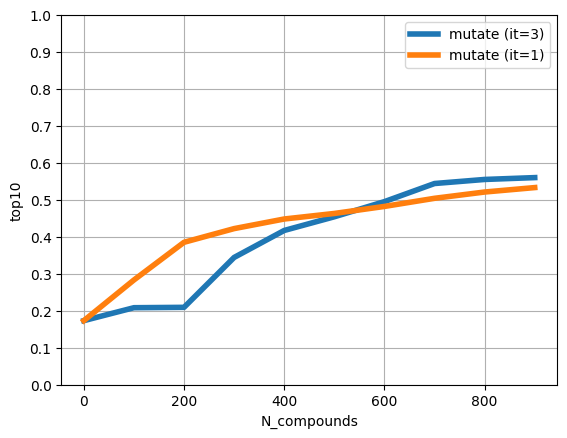

In [354]:
# 5. Run mutation loop
mloop_it1 = MutateLoop(base_dir="mutate", n_warmup_iterations=1, user_token=YOUR_TOKEN, target="GSK3β_server")
mutate_metrics_it1 = run(mloop_it1, purge=True, budget=1000, steps=10)

mloop_it3 = MutateLoop(base_dir="mutate", n_warmup_iterations=3, user_token=YOUR_TOKEN, target="GSK3β_server")
mutate_metrics_it3 = run(mloop_it3, purge=True, budget=1000, steps=10)

# 5. Plot metrics using matplotlib
plt.plot([i*100 for i in range(len(mutate_metrics_it3))],
          [m['top10'] for m in mutate_metrics_it3], linewidth=4, label="mutate (it=3)")
plt.plot([i*100 for i in range(len(mutate_metrics_it1))],
          [m['top10'] for m in mutate_metrics_it1], linewidth=4, label="mutate (it=1)")
plt.legend()
plt.grid()
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('N_compounds')
plt.ylabel('top10')
plt.show()

# Chapter 3: Machine Learning To Select Compounds More Efficiently



### 📝 Automate the process

Your reports drew the attention of stakeholders, and now the company asks you if you can make more accurate predictions, as many compounds end up inactive after testing in the laboratory. Adding machine Learning is a natural idea.

Good luck!

### ⚒️ Exercise 4: Achieve meaningful correlation in molecular property prediction

We will build a simple QSAR model based on the compounds that we tested in our previous experiment. In your other projects, you could also use publicly available data. Databases such as ChEMBL offer a lot of activity data gathered from various online sources.

In the following experiment, we will use Morgan fingerprints to encode molecules. We will use them as an input to a random forest model that predicts the experimental activity. After training this model, we can use it to predict activity without paying for performing biochemical testing in a wet lab.


<img src="https://github.com/molecule-one/mlinpl-23-workshops/blob/main/assets/lab2.png?raw=true" width="400px" />

In [355]:
# Let's load all mutated compounds
mutate_cmpds = sum([mloop.load(iteration_id=i) for i in range(mloop.n_iterations)], [])

# And build dataset
data = pd.DataFrame({
    'activity': [mol.activity for mol in mutate_cmpds],
    'smiles': [mol.smiles for mol in mutate_cmpds],
    'synthesizability': [mol.synth_score for mol in mutate_cmpds],
})

In [356]:
# We need to featurize compounds
from rdkit.Chem import AllChem
import numpy as np

def calculate_fingerprint(smiles: str) -> np.ndarray:

    mol = rdkit.Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=256)

    return fp

data['fingerprint'] = data.smiles.apply(calculate_fingerprint)
data = data[data['activity']>=0]
data.head(10)

,activity,smiles,synthesizability,fingerprint
0,0.00,CCOc1ccc(CCC(=O)N2CCc3ccc(Cl)cc3C2)cc1,1.920723,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
1,0.01,Cc1ccc(Oc2ccc(N)c(C(F)(F)F)c2)cc1C,1.988021,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,0.10,O=C(Cc1ccc(CNC(=O)c2cnc3c(c2)NC(=O)CO3)cc1)Nc1...,2.365217,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ..."
3,0.03,CCn1cc(C(=O)Nc2cc(C)nn2-c2ccccc2C(F)(F)F)cn1,2.406808,"[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ..."
4,0.05,Cc1ccc(C(=O)N(C)[C@@H](C)c2cccnc2)c(C)n1,2.644888,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,0.22,Cc1ccc(-c2ccc(-c3ccn[nH]3)cc2)c(N)[nH+]1,3.182960,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,0.03,CC[C@@H](C)n1ncc2c(C(=O)N3CCC(c4noc(C)n4)CC3)c...,3.151195,"[1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ..."
7,0.01,CC(=O)N1C=Cc2ccccc2[C@@H]1CC(=O)N1CCN(S(=O)(=O...,2.885020,"[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
8,0.06,Cc1cnn(C)c1C(=O)/N=c1/sc2c(C)ccc(C)c2n1C,2.773025,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
9,0.01,O=S(=O)(c1ccc(F)cc1F)N1CCC(O)(C(F)(F)F)CC1,2.576325,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [357]:
from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming data is already loaded
X_data, y_data = np.stack(data['fingerprint']), data.activity

# Split the data into training and testing sets with a given proportion, for example, 80% for training and 20% for testing.
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)
R = model.score(X_test, y_test)
print(R)

0.9274778244485304


ρ =  0.9572460999411846


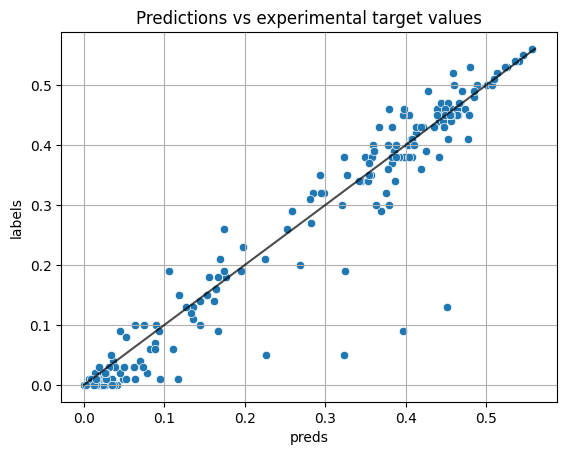

In [358]:
df_preds = pd.DataFrame({'preds': model.predict(X_test), 'labels': y_test})
corr = df_preds.corr('spearman').iloc[1, 0]
print("ρ = ", corr)
plt.plot([min(y_test),max(y_test)], [min(y_test),max(y_test)], c='black', alpha=0.7)
sns.scatterplot(data=df_preds, x='preds', y='labels')
plt.title("Predictions vs experimental target values")
plt.grid(True)
plt.show()

In [359]:
assert corr > 0.8

### Optional: Graph neural networks

You can also use graph neural networks.

<img src="https://github.com/molecule-one/mlinpl-23-workshops/blob/main/assets/lab3.png?raw=true" width="400px" />

In [360]:
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [361]:
def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise ValueError("input {0} not in allowable set{1}:".format(
            x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))


def one_of_k_encoding_unk(x, allowable_set):
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))


def _featurize_graph(smiles: str):
    mol = Chem.MolFromSmiles(smiles)

    A = np.zeros((mol.GetNumAtoms(), mol.GetNumAtoms()))
    for bond in mol.GetBonds():
      ### TODO: Add bonds to the adjacency matrix
        BeginAtom, EndAtom = bond.GetBeginAtom(), bond.GetEndAtom()
        i, j = BeginAtom.GetIdx(), EndAtom.GetIdx()

        val = mol.GetBondBetweenAtoms(
					BeginAtom.GetIdx(),
					EndAtom.GetIdx()
				).GetBondTypeAsDouble()

        A[i, j] = val
        A[j, i] = val

    nodes = []
    for atom in mol.GetAtoms():
        ### TODO: Improve the atom encoding suggested below
        results = one_of_k_encoding_unk(
            atom.GetSymbol(),
            ['C', 'O', 'N', 'Cl', 'F', 'S', '']
        )
        nodes.append(results)
    X = np.array(nodes).astype(float)

    return X, A

In [362]:
X, A = _featurize_graph('c1ccccc1')
assert X.shape[0] == 6
assert A.shape == (6, 6)
A

array([[0. , 1.5, 0. , 0. , 0. , 1.5],
       [1.5, 0. , 1.5, 0. , 0. , 0. ],
       [0. , 1.5, 0. , 1.5, 0. , 0. ],
       [0. , 0. , 1.5, 0. , 1.5, 0. ],
       [0. , 0. , 0. , 1.5, 0. , 1.5],
       [1.5, 0. , 0. , 0. , 1.5, 0. ]])

## A better featurizer

In [363]:
def featurize_graph(smiles: str):
    mol = Chem.MolFromSmiles(smiles)

    A = np.zeros((mol.GetNumAtoms(), mol.GetNumAtoms()))
    for bond in mol.GetBonds():
      ### TODO: Add bonds to the adjacency matrix
        BeginAtom, EndAtom = bond.GetBeginAtom(), bond.GetEndAtom()
        i, j = BeginAtom.GetIdx(), EndAtom.GetIdx()

        val = mol.GetBondBetweenAtoms(
                    BeginAtom.GetIdx(),
                    EndAtom.GetIdx()
                ).GetBondTypeAsDouble()

        A[i, j] = val
        A[j, i] = val

    X = []
    for atom in mol.GetAtoms():
        attributes = []
        ### TODO: Improve the atom encoding suggested below
        attributes += one_of_k_encoding_unk(
            atom.GetSymbol(),
            ['C', 'O', 'N', 'Cl', 'F', 'S', '']
        )
        # Add atomic number
        attributes += one_of_k_encoding_unk(
            atom.GetAtomicNum(), 
            [5, 6, 7, 8, 9, 15, 16, 17, 35, 53, 0]
        )
        # Add heavy neighbor count
        attributes += one_of_k_encoding(
            len(atom.GetNeighbors()),
            [0, 1, 2, 3, 4, 5]
        )
        # Add hydrogen count
        attributes += one_of_k_encoding(
            atom.GetTotalNumHs(),
            [0, 1, 2, 3, 4]
        )
        # Add formal charge
        attributes.append(atom.GetFormalCharge())
        # Add boolean if in ring
        attributes.append(atom.IsInRing())
        # Add boolean if aromatic atom
        attributes.append(atom.GetIsAromatic())
        # Add explicit valence
        attributes.append(atom.GetExplicitValence())
        # Add a number of radical electrons - The odd number of electron(s) of a free radical makes it unstable, short lived and highly reactive
        attributes.append(atom.GetNumRadicalElectrons())

        attributes = np.array(attributes).astype(float)
        X.append(attributes)

    X = np.stack(X)
    return X, A

In [364]:
X, A = featurize_graph('c1ccccc1')
assert X.shape[0] == 6
assert A.shape == (6, 6)
X.shape

print(A)

[[0.  1.5 0.  0.  0.  1.5]
 [1.5 0.  1.5 0.  0.  0. ]
 [0.  1.5 0.  1.5 0.  0. ]
 [0.  0.  1.5 0.  1.5 0. ]
 [0.  0.  0.  1.5 0.  1.5]
 [1.5 0.  0.  0.  1.5 0. ]]


In [365]:
def collate_graphs(batch):
  X_all = []
  A_all = []
  for data in batch:
    X, A = featurize_graph(data.smiles)
    X_all.append(X)
    A_all.append(A)
  max_size = max([A.shape[0] for A in A_all])
  A_padded = np.zeros((max_size * len(X_all), max_size))
  for i, A in enumerate(A_all):
    A_padded[i * max_size:i * max_size + A.shape[0], 0:A.shape[0]] = A
  X_padded = np.zeros((max_size * len(X_all), X_all[0].shape[1]))
  for i, X in enumerate(X_all):
    X_padded[i * max_size:i * max_size + X.shape[0], :] = X
  return (
      torch.Tensor(X_padded),
      torch.Tensor(A_padded),
      torch.Tensor([data.activity for data in batch]),
  )

In [366]:
data = [cmpd for cmpd in mutate_cmpds if cmpd.activity >= 0]

In [367]:
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)
train_loader = DataLoader(
    data_train,
    batch_size=8,
    collate_fn=collate_graphs,
    shuffle=True,
)
test_loader = DataLoader(
    data_test,
    batch_size=8,
    collate_fn=collate_graphs,
    shuffle=False,
)

In [368]:
import math
from typing import List


def mean_pool(X, batch_size):
    pool = X.view(batch_size, -1, X.shape[1])
    return pool.mean(dim=1)


class GCNLayer(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.W = torch.nn.parameter.Parameter(torch.empty((in_features, out_features)))
        torch.nn.init.kaiming_uniform_(self.W, a=math.sqrt(5))

    def forward(self, X, A):
        size = A.shape[1]
        X_new = []
        A = A.view(-1, size, size)
        X = X.view(-1, size, X.shape[1])

        for adj, x in zip(A, X):

            # A_hat = A + I
            A_hat = adj + torch.eye(size)

            # print(F"Adjacency matrix: {adj}")
    
            # Create diagonal degree matrix D
            ones = torch.ones(size, size)
            D = torch.matmul(A_hat.float(), ones.float())
        
            # Extract the diagonal elements
            D = torch.diag(D)
        
            # Create a new tensor with the diagonal elements and zeros elsewhere
            D = torch.diag_embed(D)
        
            # Create D^{-1/2}
            D_neg_sqrt = torch.diag_embed(torch.diag(torch.pow(D, -0.5)))
            # print(D_neg_sqrt)
        
            # D^-1/2 * (A_hat * D^-1/2)
            support_1 = torch.matmul(D_neg_sqrt, torch.matmul(A_hat, D_neg_sqrt))
        
            # (D^-1/2 * A_hat * D^-1/2) * (X * W)
            output = torch.matmul(support_1, torch.matmul(x, self.W))
            
            X_new.append(output)

        return torch.concatenate(X_new)


class GraphNeuralNetwork(torch.nn.Module):

    def __init__(self, model_dim: List[int], dropout_rate: List[float],
                 input_dim: int = 100, output_dim: int = 1):

        assert len(model_dim) == len(dropout_rate), f'Specified {len(model_dim)} convolutional layers, but {len(dropout_rate)} dropout rates '

        super().__init__()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        self.model_dim = model_dim
        self.layers_num = len(model_dim)
        self.dropout_rate = dropout_rate

        self.conv_layers = [GCNLayer(in_features=input_dim, out_features=model_dim[0])] + \
                           [GCNLayer(in_features=model_dim[i], out_features=model_dim[i+1]) \
                            for i in range(0, self.layers_num-1)]

        self.drop_layers = [torch.nn.Dropout(p = self.dropout_rate[j])
                            for j in range(self.layers_num)]

        self.conv_layers = torch.nn.ModuleList(self.conv_layers)
        self.drop_layers = torch.nn.ModuleList(self.drop_layers)
        self.out_layer = torch.nn.Linear(model_dim[-1], output_dim)

    def forward(self, batch):

        X, A, y = batch
        batch_size = len(y)
        X = X.type(torch.FloatTensor)
        X, A = X.to(self.device), A.to(self.device)

        # Apply convolutional layers
        for i in range(self.layers_num):                    
            X = self.conv_layers[i](X, A)
            X = self.drop_layers[i](X)
            X = F.relu(X, inplace=False)

        # Apply mean pooling
        X = mean_pool(X, batch_size)

        # Apply final linear layer
        X = self.out_layer(X)

        return X

In [369]:
from tqdm.notebook import tqdm, trange

def train(train_loader):
    ### TODO: define and choose your hyperparameters
    # hyperparameters definition
    hidden_sizes = [128, 128]
    dropouts = [0.2, 0.1]
    for molecules in train_loader:
        break
    input_dim = molecules[0].shape[1]
    epochs = 100
    learning_rate = 0.005

    # model preparation
    model = GraphNeuralNetwork(model_dim=hidden_sizes, dropout_rate=dropouts, \
                               input_dim=input_dim, output_dim=1)

    model.train()
    model = model.to(model.device)

    # training loop
    optimizer =  torch.optim.Adam(model.parameters(), lr=learning_rate) ### TODO: define an optimizer
    loss_fn = torch.nn.MSELoss()  ### TODO: define a loss function
    for epoch in trange(1, epochs + 1, leave=False):
        for data in tqdm(train_loader, leave=False):
            y = data[2]
            model.zero_grad()
            preds = model(data)
            loss = loss_fn(preds, y.reshape(-1, 1))
            loss.backward()
            optimizer.step()
    return model


def predict(model, test_loader):
    # evaluation loop
    preds_batches = []
    with torch.no_grad():
        for data in tqdm(test_loader):
            preds = model(data)
            preds_batches.append(preds.cpu().detach().numpy())
    preds = np.concatenate(preds_batches)
    return preds


# training
model = train(train_loader)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

ρ =  0.9203247622565554


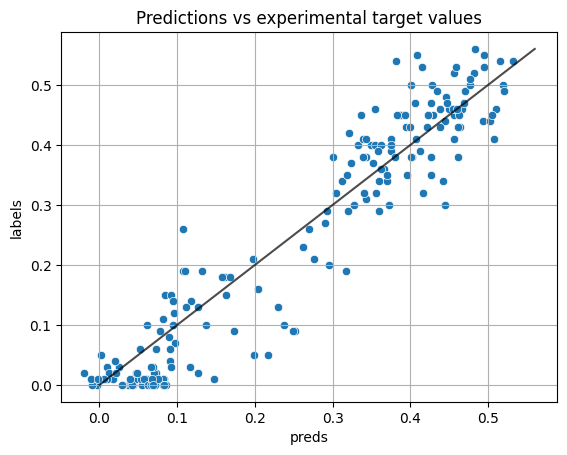

In [370]:
df_preds = pd.DataFrame({
    'preds': predict(model, test_loader).flatten(),
    'labels': [cmpd.activity for cmpd in data_test],
})

corr = df_preds.corr('spearman').iloc[1, 0]
print("ρ = ", corr)
plt.plot([min(y_test),max(y_test)], [min(y_test),max(y_test)], c='black', alpha=0.7)
sns.scatterplot(data=df_preds, x='preds', y='labels')
plt.title("Predictions vs experimental target values")
plt.grid(True)
plt.show()

In [371]:
assert corr > 0.75

### ⚒️ Exercise 5: Machine Learning Based Loop

In [372]:
# 1. Initialize a base loop that mutates compounds based on the input candidates
base_loop = MutateLoop(
    base_dir='mlloop',
    n_warmup_iterations=3,
    user_token=YOUR_TOKEN,
    target='GSK3β_server',
)

Found local copy...
Loading...
Done!


[22:49:46] Saving results to mlloop.                                                                  ]8;id=354339;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=403724;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#44\44]8;;\

In [374]:
# 2. Implement active learning loop that mutates compounds and filters the candidates using ML predictive models

from pathlib import Path
from typing import List

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


class MLLoop(Loop):
    """
    Your final implementation of the experimental loop.

    The algorithm you implement in the `propose_candidates` method will be repeated
    several times to iteratively improve your candidates.

    The molecules will be sent to the official lab endpoint with a LIMITED NUMBER OF REQUESTS,
    so use this code wisely and care for the synthesizability of your compounds!
    """
    def __init__(self, base_dir: Path, base_loop: Loop, n_warmup_iterations: int=1, user_token=None, target="DRD2", model=None):
        self.base_loop = base_loop
        self.n_warmup_iterations = n_warmup_iterations
        self._model = model
        super().__init__(base_dir, user_token, target)

    def _featurize(self, smi: List[str]) -> np.ndarray:
        fps = []
        for smiles in smi:
            mol = rdkit.Chem.MolFromSmiles(smiles)
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=256)
            fps.append(fp)
        fps = np.stack(fps)
        
        return fps

    def _split(self, X, y, smi):
        X_temp, X_test, y_temp, y_test, smi_temp, smi_test = \
            train_test_split(X, y, smi, test_size=0.2, random_state=42)
        X_train, X_valid, y_train, y_valid, smi_train, smi_valid = \
            train_test_split(X_temp, y_temp, smi_temp, test_size=0.2, random_state=42)
        return X_train, X_valid, X_test, y_train, y_valid, y_test, smi_train, smi_valid, smi_test

    def _train_model(self, previous_results: List[LeadCompound]):
        """Trains models and assigns to ._model variable."""
        
        previous_results = [c for c in previous_results if c.activity != -1]
        if len(previous_results) == 0:
            raise ValueError("No previous results to train on (excluded activity = -1). Perhaps your "
                             "base loop proposes nonsynthetizable compounds?")
        console.log(f"Retraining model on {len(previous_results)} compounds.")
        smi = [c.smiles for c in previous_results]
        X = self._featurize(smi)
        y = np.array([c.activity for c in previous_results])
        # y = y > np.median(y) # convert to binary. loses information naturally.

        console.log(f"Shapes: X {X.shape}, y {y.shape}")

        # split using sklearn
        X_train, X_valid, X_test, y_train, y_valid, y_test, smi_train, smi_valid, smi_test = self._split(X, y, smi)

        console.log(f"Training set size: {len(X_train)}")
        console.log(f"Validation set size: {len(X_valid)}")
        console.log(f"Test set size: {len(X_test)}")
        console.log(f"Training set activity mean: {np.mean(y_train)}")
        console.log(f"Proceeding to training Random Forest")
        # rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)

        self._model = rf

    def _select_top_N(self, candidates: List[LeadCompound], n_select: int) -> List[LeadCompound]:
        """Ranks candidates by their predicted activity."""
        X_test = self._featurize([c.smiles for c in candidates])
        synth = [c.synth_score for c in candidates]
        y_pred = self._model.predict(X_test)
        if y_pred.ndim == 2:
            y_pred = y_pred[:, -1]
        return [c for _, _, c in sorted(zip(y_pred, synth, candidates), reverse=True, key=lambda a: (a[0], a[1]))][:n_select]

    def propose_candidates(self, n_candidates: int) -> List[LeadCompound]:
        if self.n_iterations < self.n_warmup_iterations:
            return self.base_loop.propose_candidates(n_candidates)

        previous_results: List[LeadCompound] = self.load()
        if n_candidates == 0:
            return []

        self._train_model(previous_results)  # get the ml model
        candidates = self._select_top_N(previous_results, n_select=int(n_candidates//10))
        selfies = [encoder(m.smiles) for m in candidates]
              
        new_compounds = []
        while len(set(new_compounds)) < n_candidates:
            for selfie in selfies:
                new_selfie = decoder(mutate_selfie(selfie, max_molecules_len=100)[0])
                if compute_ertl_score(new_selfie) > 0. and compute_ertl_score(new_selfie) < 4.:
                    new_compounds.append(new_selfie)
                if len(set(new_compounds)) == n_candidates:
                    break

        new_compounds = set(new_compounds)
        assert len(new_compounds) == n_candidates
        return [LeadCompound(smiles=c) for c in new_compounds]

[22:50:28] Saving results to mlloop.                                                                  ]8;id=83165;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=98677;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#44\44]8;;\

Step 0

[22:50:37] Saving results to mlloop\0.json.                                                          ]8;id=398718;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=165750;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

[22:50:38] Saving visualization to mlloop\visualize_0.html for 100 compounds from iteration 0.        ]8;id=419786;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=469629;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['CCOc1ccc(CCC(=O)N2CCc3ccc(Cl)cc3C2)cc1', 'Cc1ccc(Oc2ccc(N)c(C(F)(F)F)c2)cc1C', 'O=C(Cc1ccc(CNC(=O)c2cnc3c(c2)NC(=O)CO3)cc1)Nc1ccccc1F', 'CCn1cc(C(=O)Nc2cc(C)nn2-c2ccccc2C(F)(F)F)cn1', 'Cc1ccc(C(=O)N(C)[C@@H](C)c2cccnc2)c(C)n1', 'Cc1ccc(-c2ccc(-c3ccn[nH]3)cc2)c(N)[nH+]1', 'CC[C@@H](C)n1ncc2c(C(=O)N3CCC(c4noc(C)n4)CC3)cc(C)nc21', 'CC(=O)N1C=Cc2ccccc2[C@@H]1CC(=O)N1CCN(S(=O)(=O)c2ccc(C)cc2)CC1', 'Cc1cnn(C)c1C(=O)/N=c1/sc2c(C)ccc(C)c2n1C', 'O=S(=O)(c1ccc(F)cc1F)N1CCC(O)(C(F)(F)F)CC1', 'Cc1cccc(CN(C2CC2)S(=O)(=O)c2ccc3c(c2)C(=O)N(C)C3=O)c1', 'CCn1cnnc1CNC(=O)c1cccc(F)c1Cl', 'Cc1c(C#N)c2ccccc2n1CC(=O)N1CC[C@H](O)C[C@@H]1C(=O)[O-]', 'O=C(NNC(=O)c1cc(F)cc(F)c1)c1cccc(O)c1', 'O=C(NNC(=O)[C@H]1[C@@H](C(=O)[O-])[C@H]2CC[C@@H]1C2)c1cccc(Cl)c1', 'C[C@@H](NC(=O)CN(C)c1ccccc1)c1ccccc1Cl', 'CC[C@@H](O)CN(Cc1cccc(C(=O)N(C)C)c1)c1ccccc1', 'Cc1ccccc1CN1CC[NH+](CC(=O)Nc2cccc3nonc23)CC1', '[O-]C1=NC(=S)S/C1=C\\c1ccc(CSC(F)F)o1', 'O=C(c1cn(C2CCN(S(=O)(=O)c3c(F)cccc3F)CC2)nn1)N1CCCCC1', 'COCC[NH+]1CCc2nc(S

MolGridWidget()

Step 1

[22:50:48] Saving results to mlloop\1.json.                                                          ]8;id=941362;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=498871;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop\visualize_1.html for 100 compounds from iteration 1.        ]8;id=857031;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=557587;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['CCCCNC(=O)c1cccn(-c2ccc(NC(=O)c3ccc(C)cc3)cc2)c1=O', 'CC(=O)NC[C@H]1CCCN(C(=O)[C@@H]2CCO[C@H]2C)C1', 'COc1cc(OC)c(OC)cc1C[NH2+][C@H](C)c1ccc(Br)cc1', 'Cc1cccc(Cn2cccc(C(=O)NC[C@@H](O)c3ccccc3)c2=O)c1', 'CCc1ccc(C(=O)[C@H](C)Sc2nnc([C@H]3CCS(=O)(=O)C3)n2C)cc1', 'Oc1ccccc1C1OCCO1', 'CC(=O)Nc1cccc(NC(=O)[C@H](NC(=O)c2cccc(C)c2)C(C)C)c1', 'CSC1=C(C#N)[C@@H](c2ccco2)C(C(=O)Nc2ccccc2)=C(C)N1', 'CCOC(=O)C1(C(=O)C2CC2)CC2(CCCCC2)C1', 'CC(C)CCO[C@@H]1CCN(C(=O)c2cc(F)ccc2O)C1', 'CC[C@@H](C)NC(=O)c1ccc(NC(=O)N[C@@H]2CCCc3ccccc32)cc1', 'CC(=O)c1cccc(NC(=O)CCc2c(F)cccc2F)c1', 'Cc1[nH+]ccn1CCCNC(=O)c1cccc(Br)c1O', 'COC(=O)[C@@H]1CCCCC[C@H]1NC(=O)Nc1ccc(OC)c(C)c1', 'Cc1cc(C)n2nc(SCc3ccc(Br)cc3F)nc2n1', 'CC(C)c1ccc(NC(=O)CNc2cccc([N+](=O)[O-])c2)cc1', 'Fc1cccc(Cc2nc3ccccc3[nH]2)c1F', 'CC(C)C[C@H](NC(=O)OC(C)(C)C)/C(N)=N/O', 'C[C@H]1CCCC[C@@H]1CNC(=O)N1CCC(Oc2ccnc(C(N)=O)c2)CC1', 'CNC(=O)c1cc2cc(F)ccc2[nH]1', 'CCc1nc(C)sc1CN1C[C@@H]2CC[C@H](C1)[NH+](CC=C(C)C)C2', 'COc1ccc(N2CCN(C(=O)[C@H]3N=NC4=C3CSc

MolGridWidget()

Step 2

[22:50:58] Saving results to mlloop\2.json.                                                          ]8;id=243916;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=950201;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop\visualize_2.html for 100 compounds from iteration 2.        ]8;id=98231;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=737929;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['CNC(=O)c1ccsc1NC(=O)Cc1ccc2ccccc2c1', 'C[C@@H](C(=O)Nc1ccccc1C#N)[NH+]1CCN(c2cccc(Cl)c2)CC1', 'COc1cc(C[NH+](C)CC(=O)NCC2CCCCC2)ccc1O', 'C[NH+](C)[C@@H]1CC[C@H](NC(=O)NCc2ccc(N3CCSCC3)cc2)C1', 'Cc1cccc(OCCn2c([C@@H](C)NC(=O)[C@H]3CCCO3)nc3ccccc32)c1C', 'CCC[C@H]1NC(=O)CCN([C@@H](C)c2c(C)noc2C)C1=O', 'COc1ccc([C@@H]2CC(=O)c3cn4nc(SCc5cccc(C)c5)nc4nc3C2)c(OC)c1', 'CC[NH2+][C@@H]([C@@H]1CCOC1)[C@@H]1CCOC2(CCCCC2)C1', 'COc1ccc(F)cc1NC(=O)[C@H]1CC(=O)N(c2ccccc2OC)C1', 'COc1ccc(NC(=O)C[C@H](c2ccccc2)n2cccc2)c(OC)c1', 'CC(C)(C)n1nccc1NC(=O)C(=O)NCC[NH+]1CCCCCC1', 'Cc1cc(C)nc(NC(=O)[C@@H]2CSc3nccc(=O)n3C2)n1', 'Cc1ccc(CC(=O)[O-])n1-c1ccc(F)cc1', 'COc1ccc(OCc2nnc(S[C@@H](C)C#N)n2-c2ccccc2)cc1', 'COc1ccc2c(c1OC)C(=O)N1[C@H](C(=O)NCCC(C)C)CS[C@H]21', 'NC(=O)c1c(NC(=O)c2ccc([N+](=O)[O-])cc2Cl)sc2c1CCCCC2', 'CCC1CCC([NH3+])(c2nnc3ccncn23)CC1', 'CCOC(=O)c1c(NC(=O)c2nnn(-c3ccc(C)cc3)c2C)sc2c1CC[C@@H](C)C2', 'O=C(Cc1ccccc1Cl)N1CCN(S(=O)(=O)c2ccc(Br)cc2Cl)CC1', 'O=C(Cn1c(=O)oc2cc(Cl)ccc21)N1CCC[C@@H]

MolGridWidget()

Step 3

[22:50:58] Retraining model on 259 compounds.                                                      ]8;id=150389;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=275885;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#52\52]8;;\

           Shapes: X (259, 256), y (259,)                                                          ]8;id=451654;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=897336;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#58\58]8;;\

           Training set size: 165                                                                  ]8;id=639633;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=461308;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#63\63]8;;\

           Validation set size: 42                                                                 ]8;id=691248;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=330996;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#64\64]8;;\

           Test set size: 52                                                                       ]8;id=481696;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=52277;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#65\65]8;;\

           Training set activity mean: 0.02757575757575757                                         ]8;id=138644;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=767765;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#66\66]8;;\

           Proceeding to training Random Forest                                                    ]8;id=588102;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=858158;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#67\67]8;;\

[22:51:10] Saving results to mlloop\3.json.                                                          ]8;id=585710;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=300221;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop\visualize_3.html for 100 compounds from iteration 3.        ]8;id=197793;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=858401;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['CCCOCC(=O)N(C)CC1=C(C=C2C=C(OC)CC=C2)[NH1]N1', 'CCCBr', 'C1C=CC=C(C2=CC=C(C3=CC=N[NH1]3)C=C2)C(N)=[NH1+1]1', '[S+1]CCCOC1=NC=NC(NC2=CC(Cl)=CC(Cl)=C2)=C1N', 'COC1=CC(/C=N/N=C2/NC(=O)[C@@H1](NC(=O)C3=CC=C(C)C(C)=C3)S2)=CC=C1O', 'O=C([P+1]CC1=CC=C(CNC(=O)C2=CN=C3C(=C2)NC(=O)CO3)C=C1)NC4=CC=CC=C4F', 'CCCOCC(=O)N(C)CC=C=NNC1=CC=C(OC)C=C1[NH1]N', 'O=C(CC=CC=O)NC1=CC=CC=C1F', 'O=C(CC1=CC=C(C#[P+1]C(=O)C2=CN=C3C(=C2)NC(=O)CO3)C=C1)NC4=CC=CC=C4F', 'CC#[S+1]COC1=NC=NC(NC2=CC(Cl)=CC(Cl)=C2)=C1N', 'C#CC1=NC=NC(NC2=CC(Cl)=CC(Cl)=C2)=C1N', 'CC1=CC=C(C2=CC=C(C3=CC=N[NH1]3)C=C2)C(N)=[NH1+1]1', 'CCCOCC(=O)N(C)C=1C=NC2=CC=C(OC)C=C2[NH1]N=1', 'C=CC1=NC=NC(NC2=CC(Cl)=CC(Cl)=C2)=C1N', 'CCCPOCC(=O)N(C)C=1C=C(C2=CC=C(OC)C=C2)[NH1]N=1', 'CCCOCC(=O)N(CCC=1C=CC2=CC=C(OC)C=C2)[NH1]N=1', 'CCOC(=[C-1])NC1=CC(C2=N[C@H1](C(=O)OC)CO2)=CC=N1', 'COC1=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CC=[B+1])SC=C1OC', 'NPC1=CC=C(C2=C(F)C=C(F)C=C2F)C=N1', 'CCCOCC(=O)N(C)CC=C(C1=CC=C(OC)C=C1)[NH1]N', 'CCCCl', 'CCCOC1=NC=NC(N

MolGridWidget()

Step 4

[22:51:11] Retraining model on 359 compounds.                                                      ]8;id=247702;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=473821;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#52\52]8;;\

           Shapes: X (359, 256), y (359,)                                                          ]8;id=418940;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=367906;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#58\58]8;;\

           Training set size: 229                                                                  ]8;id=961618;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=43397;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#63\63]8;;\

           Validation set size: 58                                                                 ]8;id=540764;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=101644;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#64\64]8;;\

           Test set size: 72                                                                       ]8;id=578371;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=252693;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#65\65]8;;\

           Training set activity mean: 0.05982532751091703                                         ]8;id=488123;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=401352;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#66\66]8;;\

           Proceeding to training Random Forest                                                    ]8;id=182428;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=635136;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#67\67]8;;\

[22:51:24] Saving results to mlloop\4.json.                                                          ]8;id=23752;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=490848;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop\visualize_4.html for 100 compounds from iteration 4.        ]8;id=324402;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=159656;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['O=C(O)PC1=C[NH1]C2=NC=CC(Cl)=C12', 'BrCOC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCC[B-1])C=C1OC', 'C1OC=CC=C1C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C', 'C1OC=CC=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C1ONC', 'C1OC=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)C#N)C1OC', 'O=S(=O)(CCl)N1CCCC[C@@H1]1C2OCCO2', 'C1C=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCC=N4)C=C1OC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1)CCCC)C=COC', 'COC=CC=C(C(=O)C=1SC2=NC3=C(C(C4=CC=NC=C4)=C2C=1N)CCCC3)COC', 'COC1=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CC=[B+1])SC=C1OC', 'COC=C1CN(C(=O)CSC2=NC=C(C(C3=CC=NC=C3)=C2CBr)NCCCC)C=C1OC', 'CC1=C(C(=[S+1])OC=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'CNOC=CC=C(C(=O)C=1SC2=NC3=C(C(C4=CC=NC=C4)=C2C=1N)CCCC3)C=COC', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCC(C)[C@@H1]C3OCCO3', 'CC1=C(CC(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)C=4CC=4S)C=COC', 'C1C=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=

MolGridWidget()

Step 5

[22:51:24] Retraining model on 459 compounds.                                                      ]8;id=319591;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=479187;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#52\52]8;;\

           Shapes: X (459, 256), y (459,)                                                          ]8;id=38298;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=160327;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#58\58]8;;\

           Training set size: 293                                                                  ]8;id=720585;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=120029;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#63\63]8;;\

           Validation set size: 74                                                                 ]8;id=684934;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=945654;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#64\64]8;;\

           Test set size: 92                                                                       ]8;id=110371;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=81853;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#65\65]8;;\

           Training set activity mean: 0.10187713310580206                                         ]8;id=361987;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=650633;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#66\66]8;;\

           Proceeding to training Random Forest                                                    ]8;id=104895;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=77577;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#67\67]8;;\

[22:51:36] Saving results to mlloop\5.json.                                                          ]8;id=71823;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=47601;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop\visualize_5.html for 100 compounds from iteration 5.        ]8;id=664004;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=56354;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N=[C-1]CCC3OCCO3', 'CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)C#[C-1])SC=COC', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NC3OCCO3', 'O=S(=O)(C=NC[NH1]C1=NC=CC(Cl)=C1)N2CCCC[C@@H1]2C3OCCO3', 'O=S(=O)(Cl)N1CCCC[C@@H1]1C2OCCO2', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCC3CCCO3', 'C1C=CO1', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC#CS)C=COC', 'O=S(=O)(C1=C[NH1]C2=NC=CC([S+1])=C12)N3CCCC[C@@H1]3C4OCCO4', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)[B+1]CCC)CCOC', 'O=S(=O)(C=C(N)C=CC(Cl)=C)NCCCC=[C@@H1]C1OCCO1', 'O=S(=O)(C=C[NH1]C=O)N1CCCC[C@@H1]1C2OCCO2', 'C1OC=CCN(C(=O)CSC2=NC=C(C(C3=CC=NC=C3)=N2)CCC=C)C=C1OC', 'O=S(=O)(C1=COC2=NC=CC(Cl)=C12)NCCCC=[C@@H1]C3OCCO3', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCC[B-1])C=C1O', 'CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CS)C=COC', 'C#[C+1]C1=CCN(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1OC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)C=4CC=4)SC=COC', 'COC1=CC=C(C(=O)SC2=NC=C(C(C3=

MolGridWidget()

Step 6

[22:51:37] Retraining model on 559 compounds.                                                      ]8;id=322662;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=663273;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#52\52]8;;\

           Shapes: X (559, 256), y (559,)                                                          ]8;id=851796;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=842660;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#58\58]8;;\

           Training set size: 357                                                                  ]8;id=410251;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=334386;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#63\63]8;;\

           Validation set size: 90                                                                 ]8;id=711075;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=630076;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#64\64]8;;\

           Test set size: 112                                                                      ]8;id=512831;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=390573;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#65\65]8;;\

           Training set activity mean: 0.14128851540616247                                         ]8;id=990266;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=610819;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#66\66]8;;\

           Proceeding to training Random Forest                                                    ]8;id=760429;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=192553;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#67\67]8;;\

[22:51:50] Saving results to mlloop\6.json.                                                          ]8;id=606248;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=615238;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop\visualize_6.html for 100 compounds from iteration 6.        ]8;id=501351;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=700106;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['COC1=CCN(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2O)CCC=C)C=C1OC', 'COC=CCN(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC=C)C=COCN', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)C=4CC=4[O+1])C=COC', 'C[B+1]C1=CCN(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1C', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCC#N', 'O=S(=O)(C1=C[NH1]C2=NC=CC([S+1])=C12)NCCCC[C@@H1]=[N-1]', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC#CS)C=COC', 'O=S(=O)(C1=C[NH1]C2=NC=CC([S+1])=C12)N3CCCC[C@@H1]3C4OCCO4', 'O=S(=O)(C1=C[NH1]C2=NC=CC([S+1])=C12)N3CCCC[C@@H1]3COCC=O', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1[H])CC#CS)C=COC', '[S-1]COC1=CCN(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCI)CC=C1OC', 'O=S(=O)(C1=C[NH1]C2=NC=CC([S+1])=C12)NCCCC=[C@@H1]C3OCCO3', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COCCON', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC=4NC=4)CC=COC', 'COC=C1CN(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)CC=C1C', 'O=S(=O)(C[NH1]C1=NC=CC(Cl)=C1)N2CCCC[C@@H1]2C3OCCO3', '[P+1]OC

MolGridWidget()

Step 7

[22:51:50] Retraining model on 659 compounds.                                                      ]8;id=901935;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=175008;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#52\52]8;;\

[22:51:51] Shapes: X (659, 256), y (659,)                                                          ]8;id=980084;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=793069;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#58\58]8;;\

           Training set size: 421                                                                  ]8;id=691326;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=879141;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#63\63]8;;\

           Validation set size: 106                                                                ]8;id=247006;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=521300;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#64\64]8;;\

           Test set size: 132                                                                      ]8;id=684650;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=326789;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#65\65]8;;\

           Training set activity mean: 0.17638954869358667                                         ]8;id=643002;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=937722;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#66\66]8;;\

           Proceeding to training Random Forest                                                    ]8;id=906546;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=501290;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#67\67]8;;\

[22:52:05] Saving results to mlloop\7.json.                                                          ]8;id=914843;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=745890;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop\visualize_7.html for 100 compounds from iteration 7.        ]8;id=864858;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=187231;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['C1OC=CCN(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1NOCN', 'O=S(=O)(C1=C[NH1]C2=NC=CC([S+1])=C12)N3CCCC[C@@H1]3C=O', 'COC=CCN(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC=C)C=COCN', 'O=S(=O)(C1=C[NH1]C2=NC=CC([S+1])=C12)NCF', 'O=S(=O)(C1=C[NH1]C2=NC=CC([S+1])=C12)NCCCC[C@@H1](C3)OCCO3', 'O=S(=O)(C1=C[NH1]C2=NC=CC([S+1])=C12)NCCCC[C@@H1]Cl', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC#CS)C=COC', 'COC1=CCN(C(=O)CSC2=NC=C(C(C3=CC=NC=C3)=C2CCl)CCC=C)C=C1OCN', 'O=S(=O)(C1=C[NH1]C2=NC=CC([S+1])=C12)N3CCCC[C@@H1]3C4OCCO4', 'O=S(=O)(C1=C[NH1]C2=NC=CC([P+1])=C12)N3CCCC[C@@H1]3C4OCCO4', 'COC1=CCN(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)[O+1]=C1OCN', 'O=S(=O)(C1=C[NH1]C2=NC=CC([S+1])=C12)N3CCCC[C@@H1]3COCC=O', 'O=S(=O)(C1=C[NH1]C2=NC=CC([S+1])=C12)NCCCC=[C@@H1]C3OCCO3', 'C1OC=CCN(C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1OCN', 'BOC1=CCN(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1OCN', 'COC1=CCN(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2)NCCC=C)C=C1OCN', 'COC1=CCN(C(=O)C=2SC3

MolGridWidget()

Step 8

[22:52:05] Retraining model on 759 compounds.                                                      ]8;id=215903;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=940481;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#52\52]8;;\

[22:52:06] Shapes: X (759, 256), y (759,)                                                          ]8;id=667668;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=698037;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#58\58]8;;\

           Training set size: 485                                                                  ]8;id=689110;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=859134;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#63\63]8;;\

           Validation set size: 122                                                                ]8;id=339315;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=312378;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#64\64]8;;\

           Test set size: 152                                                                      ]8;id=329948;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=143521;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#65\65]8;;\

           Training set activity mean: 0.19843298969072165                                         ]8;id=959954;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=142213;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#66\66]8;;\

           Proceeding to training Random Forest                                                    ]8;id=443589;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=290277;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#67\67]8;;\

[22:52:23] Saving results to mlloop\8.json.                                                          ]8;id=527445;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=392563;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop\visualize_8.html for 100 compounds from iteration 8.        ]8;id=339810;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=881376;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['BCOC1=CCN(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC)CC=C1NOC', 'SCOC=CCNC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCCOCN', '[S-1]COC1=CCN(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1Br', '[C+1]COC1=CCN(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1NOC', '[S-1]COC1=CCN(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC)CC=C1NOC', '[N+1]OC1=CCN(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1OCN', 'BCOC1=CCN(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2)NCCC)CC=C1NOC', '[S-1]OC1=CCN(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1ON', '[S-1]OC1=CCN(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC)CC=C1OCN', 'COC1=CCN(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1[N+1]OC#C', 'COC1=CCN(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1[N+1]Br', '[C+1]COC1=CCN(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1OCN', '[S-1]COC1=CCN(C(=O)CSC2=NC=C(C(C3=CC=NC=C3)=C2I)NCCC)CC=C1OCN', '[S-1]COC=CCN(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC=C)CBr', '[S-1]COC=CCN(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCl)CC

MolGridWidget()

Step 9

[22:52:23] Retraining model on 859 compounds.                                                      ]8;id=619346;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=232929;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#52\52]8;;\

[22:52:24] Shapes: X (859, 256), y (859,)                                                          ]8;id=252626;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=18643;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#58\58]8;;\

           Training set size: 549                                                                  ]8;id=685223;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=392916;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#63\63]8;;\

           Validation set size: 138                                                                ]8;id=793961;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=651141;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#64\64]8;;\

           Test set size: 172                                                                      ]8;id=331702;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=959684;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#65\65]8;;\

           Training set activity mean: 0.21825136612021862                                         ]8;id=810711;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=464433;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#66\66]8;;\

           Proceeding to training Random Forest                                                    ]8;id=875694;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py\2496683991.py]8;;\:]8;id=915086;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\2496683991.py#67\67]8;;\

[22:52:40] Saving results to mlloop\9.json.                                                          ]8;id=350229;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=704352;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop\visualize_9.html for 100 compounds from iteration 9.        ]8;id=447397;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=97351;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['SCOC1=CCN(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)COC=C)C=C1OCN', 'SCOC1=CCN(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2)NCCC=C)C=C1ONN', 'SCOC=C1CN(C(=O)CSC2=NC=C(C(C3=CC=NC=C3)=C2CC)NCCC)CC=C1ONN', 'SCOC=C1SCN(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1OCN', '[S-1]1CN(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1NOC', 'ClCOC1=CCN(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CC)C=CC=C1NOC', 'S1COC=CCN1C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC', 'ClCOC1=CCN(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1NOC[H]', '[S-1]COC1=CCN(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC)CC=C1NOC', 'CSCOC1=CCN(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1OCN', 'SCOC1=CCN(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1CNN', 'SCOC=CCN(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC=C)C=CBr', 'SCOC1=CCN(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1OON', 'SCOC1=CCN(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2)NCCC)CC=C1[O-1]', '[S-1]COC=C1CN(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)C=CCC)CC=C1NOC', 'SCOC1=CCN(

MolGridWidget()

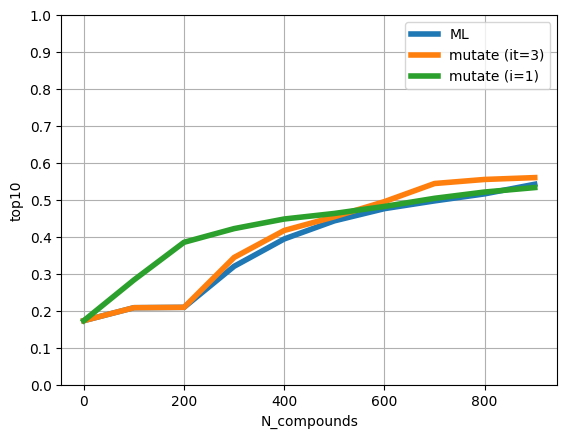

In [375]:
mlloop = MLLoop(
    base_dir="mlloop",
    base_loop=base_loop,
    user_token=YOUR_TOKEN,
    target="GSK3β_server",
    n_warmup_iterations=3
)
ml_metrics = run(mlloop, purge=True, budget=1000, steps=10)

# 5. Plot metrics using matplotlib
plt.plot([i*100 for i in range(len(ml_metrics))],
          [m['top10'] for m in ml_metrics], linewidth=4, label="ML")
plt.plot([i*100 for i in range(len(mutate_metrics_it3))],
          [m['top10'] for m in mutate_metrics_it3], linewidth=4, label="mutate (it=3)")
plt.plot([i*100 for i in range(len(mutate_metrics_it1))],
          [m['top10'] for m in mutate_metrics_it1], linewidth=4, label="mutate (i=1)")
plt.legend()
plt.grid()
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('N_compounds')
plt.ylabel('top10')
plt.show()

In [376]:
# 2. Implement active learning loop that mutates compounds and filters the candidates using ML predictive models

from pathlib import Path
from typing import List

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


class GCNMLLoop(Loop):
    """
    Your final implementation of the experimental loop.

    The algorithm you implement in the `propose_candidates` method will be repeated
    several times to iteratively improve your candidates.

    The molecules will be sent to the official lab endpoint with a LIMITED NUMBER OF REQUESTS,
    so use this code wisely and care for the synthesizability of your compounds!
    """
    def __init__(self, base_dir: Path, base_loop: Loop, n_warmup_iterations: int=1, user_token=None, target="DRD2", model=None):
        self.base_loop = base_loop
        self.n_warmup_iterations = n_warmup_iterations
        self._model = model
        super().__init__(base_dir, user_token, target)

    def _train(self, model, train_loader, epochs: int = 5):
        # hyperparameters definition
        hidden_sizes = [128, 128]
        dropouts = [0.2, 0.1]
        for molecules in train_loader:
            break
        input_dim = molecules[0].shape[1]
        learning_rate = 0.005
        model.train()
        model = model.to(model.device)
    
        # training loop
        optimizer =  torch.optim.Adam(model.parameters(), lr=learning_rate) ### TODO: define an optimizer
        loss_fn = torch.nn.MSELoss()  ### TODO: define a loss function
        for epoch in trange(1, epochs + 1, leave=False):
            for data in tqdm(train_loader, leave=False):
                y = data[2]
                model.zero_grad()
                preds = model(data)
                loss = loss_fn(preds, y.reshape(-1, 1))
                loss.backward()
                optimizer.step()
        return model

    def _select_top_N(self, candidates: List[LeadCompound], n_select: int) -> List[LeadCompound]:
        """Ranks candidates by their predicted activity."""
        candidates = [c for c in candidates if c.activity != -1]
        if len(candidates) == 0:
            raise ValueError("No previous results to train on (excluded activity = -1). Perhaps your "
                             "base loop proposes nonsynthetizable compounds?")
        console.log(f"Retraining model on {len(candidates)} compounds.")

        test_loader = DataLoader(candidates,
                                batch_size=16,
                                collate_fn=collate_graphs,
                                shuffle=False)
        
        y_pred = predict(self._model, test_loader).flatten()
        return [c for _, c in sorted(zip(y_pred, candidates), reverse=True, key=lambda a: a[0])][:n_select]

    def propose_candidates(self, n_candidates: int) -> List[LeadCompound]:
        if self.n_iterations < self.n_warmup_iterations:
            return self.base_loop.propose_candidates(n_candidates)

        print(f"A number of candidates: {n_candidates}")

        previous_results: List[LeadCompound] = self.load()
        
        if n_candidates == 0:
            return []

        train_loader = DataLoader(previous_results,
                                batch_size=4,
                                collate_fn=collate_graphs,
                                shuffle=True)
        
        self._model = self._train(self._model, train_loader, epochs=1)
        candidates = self._select_top_N(previous_results, n_select=int(n_candidates//10))
        selfies = [encoder(m.smiles) for m in candidates]
              
        new_compounds = []
        while len(set(new_compounds)) < n_candidates:
            for selfie in selfies:
                new_selfie = decoder(mutate_selfie(selfie, max_molecules_len=100)[0])
                if compute_ertl_score(new_selfie) > 0. and compute_ertl_score(new_selfie) < 4.:
                    new_compounds.append(new_selfie)
                if len(set(new_compounds)) == n_candidates:
                    break

        new_compounds = set(new_compounds)
        assert len(new_compounds) == n_candidates
        return [LeadCompound(smiles=c) for c in new_compounds]

In [377]:
# 1. Initialize a base loop that mutates compounds based on the input candidates
# np.random.seed(6)

base_loop = MutateLoop(
    base_dir='mlloop',
    n_warmup_iterations=3,
    user_token=YOUR_TOKEN,
    target='GSK3β_server',
)

Found local copy...
Loading...
Done!


[22:53:11] Saving results to mlloop.                                                                  ]8;id=571878;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=796613;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#44\44]8;;\

[22:53:16] Saving results to mlloop.                                                                  ]8;id=713824;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=699482;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#44\44]8;;\

Step 0

[22:53:25] Saving results to mlloop\0.json.                                                          ]8;id=430467;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=309103;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop\visualize_0.html for 100 compounds from iteration 0.        ]8;id=925029;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=766951;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['CCOc1ccc(CCC(=O)N2CCc3ccc(Cl)cc3C2)cc1', 'Cc1ccc(Oc2ccc(N)c(C(F)(F)F)c2)cc1C', 'O=C(Cc1ccc(CNC(=O)c2cnc3c(c2)NC(=O)CO3)cc1)Nc1ccccc1F', 'CCn1cc(C(=O)Nc2cc(C)nn2-c2ccccc2C(F)(F)F)cn1', 'Cc1ccc(C(=O)N(C)[C@@H](C)c2cccnc2)c(C)n1', 'Cc1ccc(-c2ccc(-c3ccn[nH]3)cc2)c(N)[nH+]1', 'CC[C@@H](C)n1ncc2c(C(=O)N3CCC(c4noc(C)n4)CC3)cc(C)nc21', 'CC(=O)N1C=Cc2ccccc2[C@@H]1CC(=O)N1CCN(S(=O)(=O)c2ccc(C)cc2)CC1', 'Cc1cnn(C)c1C(=O)/N=c1/sc2c(C)ccc(C)c2n1C', 'O=S(=O)(c1ccc(F)cc1F)N1CCC(O)(C(F)(F)F)CC1', 'Cc1cccc(CN(C2CC2)S(=O)(=O)c2ccc3c(c2)C(=O)N(C)C3=O)c1', 'CCn1cnnc1CNC(=O)c1cccc(F)c1Cl', 'Cc1c(C#N)c2ccccc2n1CC(=O)N1CC[C@H](O)C[C@@H]1C(=O)[O-]', 'O=C(NNC(=O)c1cc(F)cc(F)c1)c1cccc(O)c1', 'O=C(NNC(=O)[C@H]1[C@@H](C(=O)[O-])[C@H]2CC[C@@H]1C2)c1cccc(Cl)c1', 'C[C@@H](NC(=O)CN(C)c1ccccc1)c1ccccc1Cl', 'CC[C@@H](O)CN(Cc1cccc(C(=O)N(C)C)c1)c1ccccc1', 'Cc1ccccc1CN1CC[NH+](CC(=O)Nc2cccc3nonc23)CC1', '[O-]C1=NC(=S)S/C1=C\\c1ccc(CSC(F)F)o1', 'O=C(c1cn(C2CCN(S(=O)(=O)c3c(F)cccc3F)CC2)nn1)N1CCCCC1', 'COCC[NH+]1CCc2nc(S

MolGridWidget()

Step 1

A number of candidates: 100


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[22:53:26] Retraining model on 84 compounds.                                                        ]8;id=432257;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\411208711.py\411208711.py]8;;\:]8;id=154496;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\411208711.py#58\58]8;;\

  0%|          | 0/6 [00:00<?, ?it/s]

[22:53:35] Saving results to mlloop\1.json.                                                          ]8;id=448994;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=413775;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop\visualize_1.html for 100 compounds from iteration 1.        ]8;id=855584;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=468021;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['COCCCNN1C=NN=C1[S@](=O)CC2=NC3=CC=CC=C3S2', 'O=C(NC[C@H1]1CC2=CC=CC(C3=CN=CN=C3)=C2O1)C(C=CC=C(C)Cl)C', 'NCOCCCN1C=NN=C1[S@](=O)CC2=NC3=CC=CC=C3S2', 'COCCCN1C=NN=C1[S@](=O)=[C-1]CC2=NC3=CC=CC=C3S2', '[O-1]C[H]', 'CC1=CC=C(C2=CC=C(C3=CC=N[NH1]3)C=C2)C(N)=[NH1+1]1', 'O=C(NC[C@H1]1CC2=CC=CC(C3=CN=CN=C3)=C2O1)C(C4)=CC=C(Cl)C=C4CC', 'CCCC1=CC=C([C@H1]2C(C#N)=C(N)OC3=N[NH1]C([C-1])=C32)S1', 'CCCC1=CC=C([C@H1]2C(C#N)=C(N)OC3=N[NH1]C(C)=C32)S1', 'CC(O)CC(=O)N(C)C=1C=C(C2=CC=C(OC)C=C2)[NH1]N=1', 'COC1=CC=C(C(=O)C=2SC3=N[N+1]4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'COC=C1C=C(CC(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'CC1=CC=C(C2=CC=C(C3=CC=NN3)C=C2)C(N)=[NH1+1]1', 'C1(C2=CC=C(C3=CC=N[NH1]3)C=C2)C(N)=[NH1+1]1', 'CCCOCC(=O)N(C)C=1C=C([N+1]2=CC=C(OC)C=C2)[NH1]N=1', 'CCCOC1=NC=NC(NC2=CC(Cl)=CC(Cl)=[S+1]2)=C1N', 'C1C=CC=C1Cl', 'COCCCN1C=NN=C1[S@](=O)CC=NC2=CC=CC=C2S', '[S+1]C1=CC=C(C2=CC=C(C3=CC=N[NH1]3)C=C2)C(N)=[NH1+1]1', 'CCCC=CC=C([C@H1]1)C(C#N)=C(N)OC2=N[NH1]C(C)=C21', 'CC=CC=CC

MolGridWidget()

Step 2

A number of candidates: 100


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[22:53:36] Retraining model on 184 compounds.                                                       ]8;id=172309;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\411208711.py\411208711.py]8;;\:]8;id=111038;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\411208711.py#58\58]8;;\

  0%|          | 0/12 [00:00<?, ?it/s]

[22:53:47] Saving results to mlloop\2.json.                                                          ]8;id=860931;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=266282;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop\visualize_2.html for 100 compounds from iteration 2.        ]8;id=458618;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=708434;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['CO[N+1]C1=CC=C([C+1](=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'COCl', 'NC1=CC=C(C2=C(F)C=C(F)C=C2[N-1])C=N1', 'NC=CC=C(C1=C(F)C=C(F)C=C1[S+1])C#N', 'COC=C1C=C(CC(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2S)CCCC4)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCC#S)C=C1OC', 'C=NOC1=CC=C(C([S+1])C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'ClCOC=CC=C(C(=O)C=1SC2=NC3=C(C(C4=CC=NC=C4)=C2C=1N)CCCC3)C=COC', 'COC=C1C[C-1](CC(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'COC=C1C=C(CC(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'CO[N+1]C1=CC=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CC=[C+1]C4)C=C1OC', 'COC=CC=C(C(=O)C=1SC2=NC3=C(C(C4=CC=NC=C4)=C2C=1[N+1])CCCC3)C=COC', 'OC1=CC=C(C2=C(F)C=C(F)C=C2F)C=N1', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC=C)SC=COC', 'OC1=CC=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'COC=C1C=C(C(=[C-1])OC=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1C)NC

MolGridWidget()

Step 3

A number of candidates: 100


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

[22:53:48] Retraining model on 284 compounds.                                                       ]8;id=126456;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\411208711.py\411208711.py]8;;\:]8;id=740446;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\411208711.py#58\58]8;;\

  0%|          | 0/18 [00:00<?, ?it/s]

[22:53:59] Saving results to mlloop\3.json.                                                          ]8;id=287879;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=636112;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop\visualize_3.html for 100 compounds from iteration 3.        ]8;id=586555;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=513595;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['CO[N+1]C1=CC=C([C+1](=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCC#S)C=C1COC', 'COC=CC1=C(C(=O)[N+1]C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCC)SC=C1OC', 'COC=CC=C(C(=O)C=1SC2=NC3=C(C(C4=CC=NC=C4)=C2C=1N)CCCC3)C=C(NO)C#[B-1]', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC=NC=C)OC', 'SCOC=CC=CCC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)C#B', 'COC=CC1=C(CC(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C[B-1]=C1CC', 'COC=C1C=C(CC(=[S+1])C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2)NCCCC4)C=C1OC', 'OC=CC=CCC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)C#B', 'COC=CC1=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)C[P-1]CCC)SC=C1OC', 'CON[N+1]C1=CC=C([C+1](=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCC#S)C=C1OC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC=NC)CC=COC', 'C=NOC1=CC=C(C([S+1])C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'COC=CC=C(C(=O)C=1SC2=NC3=C(C(C4=CC=NC=C4)=C2C=1N)CC

MolGridWidget()

Step 4

A number of candidates: 100


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[22:54:01] Retraining model on 384 compounds.                                                       ]8;id=83524;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\411208711.py\411208711.py]8;;\:]8;id=16915;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\411208711.py#58\58]8;;\

  0%|          | 0/24 [00:00<?, ?it/s]

[22:54:12] Saving results to mlloop\4.json.                                                          ]8;id=956095;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=494423;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop\visualize_4.html for 100 compounds from iteration 4.        ]8;id=389215;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=679044;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC=C)OC', 'COC=CC=CCC(=O)OSC1=NC=C(C(C2=CC=NC=C2)=C1CN)C#B', 'COC=CC=CC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC=NCCC=COC', 'COC=CC=C(C(=O)C=1SC2=NC3=C(C(C4=CC=NC=C4)=C2C=1N)CCCC3)C=C(NO)C#[B-1]', 'CCOC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC)SC=COC', 'COC=CC=C(C(=O)CSC1=NC=C(C(C2=CC=NC=C2)=C1Br)CC#N)CSC=COC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCCC#S)COC', 'COC=CC=CSC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)C#B', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC=C)SC=C(N)OC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1F)NCC)OC=COC', 'COC=CC=C(C(=O)C=1SC2=NC3=C(C(C4=CC=NC=C4)=C2C=1N)CCCC3)C=C([B-1]O)C', '[C-1]COC=CC=C(C(=O)C=1SC2=NC3=C(C(C4=CC=NC=C4)=C2C=1N)CCCC3)C=C(NO)C', 'COC=CC=CCC(=O)C=1SC2=NN=C(C(C3=CC=NC=C3)=C2C=1N)C#B', 'CCOC=CC=C(C(=O)CSC1=NC=C(C(C2=CC=NC=C2)=C1[H])NCCC)CSC=COC', 'C1OC=C1', 'CCOC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1)NCCC=C)SC=COC', 'COC=CC=C(C(=O)CSC1=NC=C(C(C2=CC=NC=C2)=C1CC)NCCCC

MolGridWidget()

Step 5

A number of candidates: 100


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

[22:54:13] Retraining model on 484 compounds.                                                       ]8;id=268359;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\411208711.py\411208711.py]8;;\:]8;id=771014;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\411208711.py#58\58]8;;\

  0%|          | 0/31 [00:00<?, ?it/s]

[22:54:25] Saving results to mlloop\5.json.                                                          ]8;id=345189;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=379045;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop\visualize_5.html for 100 compounds from iteration 5.        ]8;id=275740;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=389341;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['[S+1]C=CC=C(C1=CC=C(C2=CC=N[NH1]2)C=C1)C(N)=[NH1+1]', 'CCOC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC)F', '[S+1]C1=CC=C(C2=CC=C(C3=CC=N[NH1]3)C=C2)CN=[NH1+1]1', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC=C)SC=CNC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCCl)NCSC=CO', 'OC=CC=CCC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)C#B', '[S+1]C=CC=C(C1=CC=C(C2=CC=N[NH1]2)C=C1)C(N3)=[NH1+1]3', 'COC=CC=CSC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)C#B', '[S+1]1C=C(C2=CC=C(C3=CC=N[NH1]3)C=C2)C(N)=[NH1+1]1', 'COC=CC=CSC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1C)NC#B', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC=NOC)C=COCC', 'C1OC=C1', 'CCOC=CC=C([B-1]C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC)F', 'OC=CC=CCC(=O)SC1=NC=C(C(C2=CC=NC=C2)=C1CN)C#B', 'COC=CC=C(C(=O)CSC1=NC=C(C(C2=CC=NC=C2)=C1CC)NCC)NCSC=CO', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC=C)SC=C(NN)Br', '[S+1]C1=CC=C(C2=CC=C(C3=CC=N[NH1]3)C=C2)C(N)=[NH1+1]1', 'N1OC=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)C#B)C=C

MolGridWidget()

Step 6

A number of candidates: 100


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

[22:54:27] Retraining model on 584 compounds.                                                       ]8;id=927826;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\411208711.py\411208711.py]8;;\:]8;id=426881;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\411208711.py#58\58]8;;\

  0%|          | 0/37 [00:00<?, ?it/s]

[22:54:39] Saving results to mlloop\6.json.                                                          ]8;id=83923;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=751262;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop\visualize_6.html for 100 compounds from iteration 6.        ]8;id=484208;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=532195;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['COC=CC=C(C=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)C[O-1]', 'COC=CC=C(C)OC=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC=NOCC=COC', 'O1C=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)SC1', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)C=O)CC=COC', 'CCOC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)[C+1]CC)F', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC=NC)CC=CCl', 'COC=CC=C(C(=O)CSC1=NC=C(C(C2=CC=NC=C2)=C1CN)CCCC)SC=C(NO)C', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC=NC)C=COC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC=NC)CC=COC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC=NC)C#[O+1]', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC=NCO)C=COC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)C=O)CSCOC', 'C(C=CC=CC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCCC)SC=C(NO)C', 'CCOC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCS)C=COC', 'C#CC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)C=O)CSC=COC', 'COC1=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)SC1=C'

MolGridWidget()

Step 7

A number of candidates: 100


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

[22:54:42] Retraining model on 684 compounds.                                                       ]8;id=653398;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\411208711.py\411208711.py]8;;\:]8;id=400194;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\411208711.py#58\58]8;;\

  0%|          | 0/43 [00:00<?, ?it/s]

[22:54:55] Saving results to mlloop\7.json.                                                          ]8;id=419231;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=734147;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop\visualize_7.html for 100 compounds from iteration 7.        ]8;id=168238;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=159472;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)NCC)NCSC=CO', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC)CSC=C(NN)OC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCCC)SC', 'C1OC=CC=C1C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CC=NCC', 'COCF', 'COC=CC=C(C)OC=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC=NOCC=COC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC#N)CSC=C=O', 'COC=CC=CC(=O)C=1SC2=NC=CC(C3=CC=NC=C3)=C2C=1NCC=NCCC=COC', 'COC=CC=C(C=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC=[B+1]', 'COC=CC=C(C(=O)CSC1=NC=C(C(C2=CC=NC=C2)=C1CN)CCC=C)SC=C(NO)C', 'OC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC#N)CSC=CO', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC=C)SC=C(N)OC', 'COC=CC=C(C(=O)CSC1=NC=C(C(C2=CC=NC=C2)=C1)CC#N)CSC=CO', 'COC=CCCl', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC=C)Br', 'COC=CC=C(C(=O)C=1SC2=NN=C(C(C3=CC=NC=C3)=C2C=1N)CC#N)CSC=CO', '[H]COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC=C)SC=C(NN)OC', 'C1OC=C1', 'CCOC=CC=CC(=O)CSC1=NC=CC(C2=CC=N

MolGridWidget()

Step 8

A number of candidates: 100


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

[22:54:57] Retraining model on 784 compounds.                                                       ]8;id=606181;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\411208711.py\411208711.py]8;;\:]8;id=817854;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\411208711.py#58\58]8;;\

  0%|          | 0/49 [00:00<?, ?it/s]

[22:55:10] Saving results to mlloop\8.json.                                                          ]8;id=904513;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=675938;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

[22:55:11] Saving visualization to mlloop\visualize_8.html for 100 compounds from iteration 8.        ]8;id=564940;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=131755;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['OC=CC=C(C=O)C=1SC2=CC=C(C(C3=CC=NC=C3)=C2C=1N)CC=NOCC=COC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=NC=NC=C3)=C2C=1N)C)C=NCCC=COC', 'CCOC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC)SC=COC', 'CCC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC=C)SC=C(NN)OC', 'COC=CC=C(C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC=C)SC=C(ON)OC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC#N)SC=C(NN)OC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC=C)SC=C(N)OC', 'OC=CC=C(C=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1)NCC=NOCC=COC', 'O1C=C1', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC=NC)CC=COC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC=C)SC=C(N)NOC', 'OC=CC=C(C=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC=NOCCC=COC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC=C)SC=COC', 'CCNOC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCS)C=COC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC=NCC)C=C[H]', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC=C)S#[C-1]', 'COC=CC=C(C(=O)C=1SC2=NC=C(C

MolGridWidget()

Step 9

A number of candidates: 100


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

[22:55:13] Retraining model on 884 compounds.                                                       ]8;id=124774;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\411208711.py\411208711.py]8;;\:]8;id=204304;file://C:\Users\annab\AppData\Local\Temp\ipykernel_1036\411208711.py#58\58]8;;\

  0%|          | 0/56 [00:00<?, ?it/s]

[22:55:26] Saving results to mlloop\9.json.                                                          ]8;id=322357;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=364705;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#120\120]8;;\

[22:55:27] Saving visualization to mlloop\visualize_9.html for 100 compounds from iteration 9.        ]8;id=178729;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=502659;file://C:\Users\annab\Desktop\Automating_Science\molecules\src\al_loop.py#66\66]8;;\

['COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)C[N-1])OCOC', 'COC=CC=CC(=O)C=1SC2=NC=CC(C3=CC=NC=C3)=C2C=1NC=O', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1NCC)NCC)C=CF', 'C1OC=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2)NC)OC1OC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)C=O)C[S+1]OC', 'COCC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)C=O)SC=C(NN)OC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC=C)SC=C(N)NOC', 'COC=CCC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC=NCC)C=CF', 'O1C=CC=C1C', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC=C)SC=COC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCF)SC=C(NO)C', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCCC)[S-1]C=C(NO)C', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC=C)SC=C(NN)Br', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)C=O)SC=C(N)NOC', 'C(C=CC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCCC)SC=C(NO)C', 'COC=CC=C(C(=O)CSC1=NC=C(C(C2=CC=NC=C2)=C1CC)NC)[P-1]Cl', 'COC=CC=C(CC=O)C=1SC2=NC=C(C(C3=CC=

MolGridWidget()

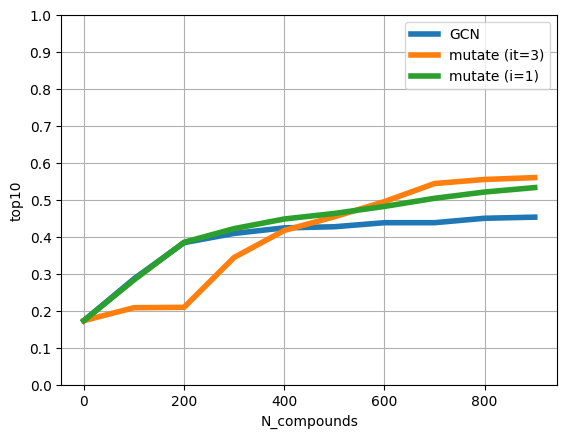

In [378]:
mlloop = GCNMLLoop(
    base_dir="mlloop",
    n_warmup_iterations=1,
    base_loop=base_loop,
    user_token=YOUR_TOKEN,
    target="GSK3β_server",
    model=model
)
gcn_ml_metrics = run(mlloop, purge=True, budget=1000, steps=10)

# 5. Plot metrics using matplotlib
plt.plot([i*100 for i in range(len(gcn_ml_metrics))],
          [m['top10'] for m in gcn_ml_metrics], linewidth=4, label="GCN")
plt.plot([i*100 for i in range(len(mutate_metrics_it3))],
          [m['top10'] for m in mutate_metrics_it3], linewidth=4, label="mutate (it=3)")
plt.plot([i*100 for i in range(len(mutate_metrics_it1))],
          [m['top10'] for m in mutate_metrics_it1], linewidth=4, label="mutate (i=1)")
plt.legend()
plt.grid()
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('N_compounds')
plt.ylabel('top10')
plt.show()

# Chapter 4: Finding drugs for all targets

The final part of the workshop is to find miracle drugs for DRD2 and JNK3 targets.

Some tips:

1. Pay attention to warmup.
2. Pay attention to synthesizability. You can compute synthesizabiltiy before sending to the lab!

```
from src.sas_score import compute_ertl_score;
compute_ertl_score(bottom100_mutate[0].smiles)```

3. Pay attention to whether you can trust your model (e.g. you might want to select very confident prediction if your model is calibrated).

In [ ]:
# your code